# Spectral Clustering of Countries Economic Development

## Introduction
This notebook aims to investigate if spectral clustering can be applied for the task of grouping the financial growth of 113 countries over the past 58 years. The whole process is documented step by step.

### Imports

In [1]:
import numpy as np

import warnings

from tslearn.clustering import silhouette_score

from Utils import DataUtils, PreProcessing, VisualUtils, TimeSeriesUtils, PostProcessing

from Clustering import SpectralClustering, KernelKMeans

### Data
For each country, three different time series of data are considered; the annual evolution of its GDP per capita, the annual evolution of its population and the annual evolution of the bilateral exchange rate of its currency against the US Dollar. While there is (partially) available data for the GDP and population evolution all the way from 1900, data about currency exchange rates is only available since 1960. For all three time series, the latest data concerns 2017. In order to stabilize the dataset, all GDP and population data before 1960 is discarded.

Because the GDP time series present very high variance, the logarithm of the series is taken instead to smoothen the results.

The data for each time series is loaded from a `.csv` file to create a $113 \times T$ matrix, where $T$ is the amount of years each time series is available for.

In [2]:
n = 113
T_gdp = 118
T_pop = 118
T_currency = 58
start_year = 1960

names_path = "Data/names.txt"
gdp_path = "Data/yp_raw.csv"
population_path = "Data/pop_raw.csv"
currency_path = "Data/currency.csv"
map_path = "Data/Map/ne_110m_admin_0_countries.shp"
locations_path = "Data/locations.csv"
groups_path = "Data/groups.txt"

In [3]:
names, gdp, pop, currency, map = DataUtils.load_clustering_data(
    names_path, gdp_path, population_path, currency_path, map_path, n, T_gdp, T_pop, T_currency
)
locations = DataUtils.load_locations(n, locations_path)
groups = DataUtils.load_groups(groups_path)
gdp_data = np.log(gdp[:, -T_currency:])
pop_data = pop[:, -T_currency:]

## Data Preparation
Before the clustering algorithms are applied, the time series data is concatenated for all countries and then standardized.

One complication that arises for currency exchange rate data when it comes to countries of former Yugoslavia and USSR. For these countries (Serbia, Croatia, Bosnia and Herzegovina and Russia respectively) no data is available until 1990. To tackle this problem, a nearest neighbor imputer is used to fill the empty values.

In [4]:
df, scaled_df = PreProcessing.preprocess(
    names, gdp_data, pop_data, currency, start_year
)

In [5]:
df_gdp, scaled_df_gdp, scaled_data_gdp = PreProcessing.preprocess_onlyGDP(names, gdp_data, start_year, T_currency)

## Spectral Clustering

We examine three different ways of building the similarity graph; a euclidean $k$-nearest neighbor graph, an $\epsilon$-neighborhood graph and a DTW $k$-nearest neighbor graph.

In order to tune the number of clusters for the algorithm, the 'eigenvalue' heuristic is used. Specifically, we examine the magnitude of the eigenvalues of the Laplacian matrix of the graph $L$, and take K clusters such that the smallest eigenvalues $\lambda_1$, ..., $\lambda_K$ are significantly smaller than the rest. Afterwards, we examine the information captured by the corresponding eigenvectors. We reduce the number of clusters by one for each eigenvector that does not capture any significant information.

### $k$-nearest neighbor graph:

We use $k=\lfloor \sqrt{n} \rfloor$ neighbors, where $n$ is the number of countries, i.e. 113. 

In [6]:
W_knn = SpectralClustering.knn_graph(n, scaled_df)

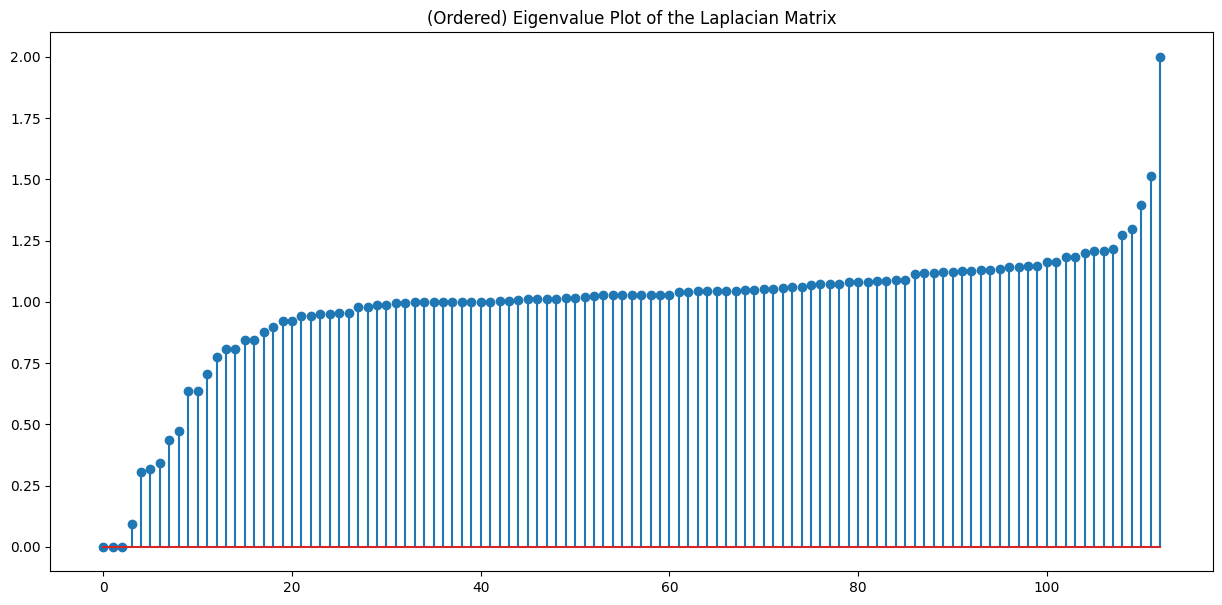

In [7]:
eigvals_knn_norm, eigvecs_knn_norm = SpectralClustering.laplacian_eigen(
    n, W_knn, True, True
)

We conclude 3 clusters are sufficient. We create the H matrix:

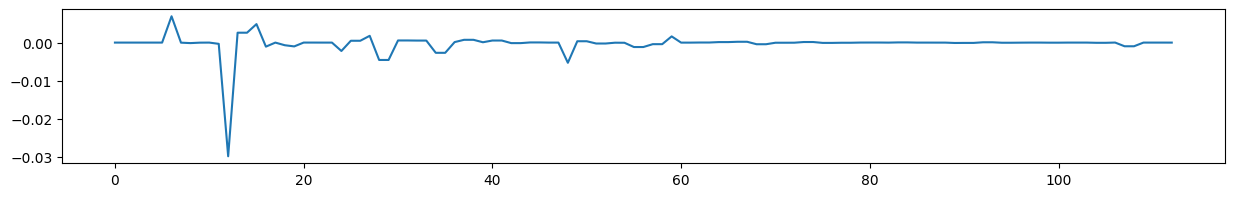

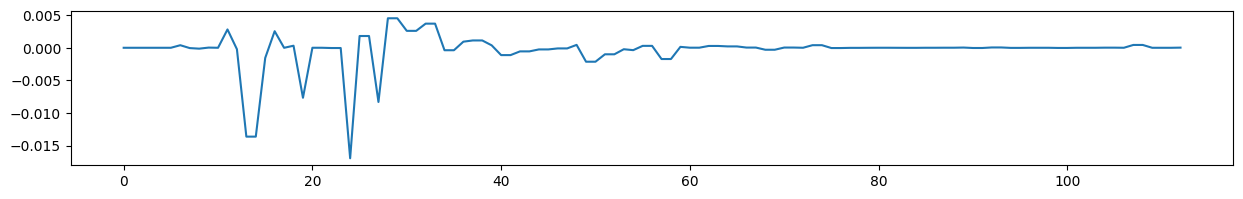

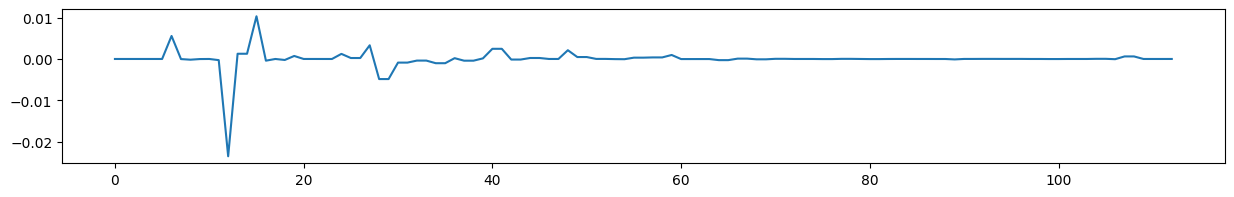

In [8]:
K_knn = 3
H_knn = SpectralClustering.smallest_eigenvecs(
    n, K_knn, eigvals_knn_norm, eigvecs_knn_norm, True
)

All of the eigenvectors are relevant, so now we can perform the clustering with 3 clusters

Silhouette Score: 0.07337984223858364
Cluster #1 size: 107
Cluster #1 members: ARG, AUS, AUT, BDI, BEL, BEN, BFA, BGD, BGR, BIH, BOL, BRA, CHL, CHN, CIV, CMR, COG, COL, CRI, DEU, DOM, DZA, EGY, ESP, ETH, FIN, FRA, GBR, GHA, GIN, GRC, GTM, HKG, HND, HRV, HTI, HUN, IDN, IND, IRL, IRN, IRQ, ISR, ITA, JOR, JPN, KEN, KHM, KOR, LAO, LBN, LBR, LKA, MAR, MDG, MEX, MLI, MMR, MNG, MOZ, MRT, MWI, MYS, NER, NGA, NIC, NLD, NOR, NPL, NZL, OMN, PAK, PAN, PER, PHL, POL, PRT, PRY, PSE, ROU, RUS, RWA, SAU, SDN, SEN, SGP, SLE, SLV, SRB, SWE, SYR, TCD, TGO, THA, TUN, TUR, TWN, TZA, UGA, URY, USA, VEN, VNM, YEM, ZAF, ZMB, ZWE
Cluster #2 size: 1
Cluster #2 members: CAF
Cluster #3 size: 5
Cluster #3 members: CAN, CHE, COD, DNK, ECU


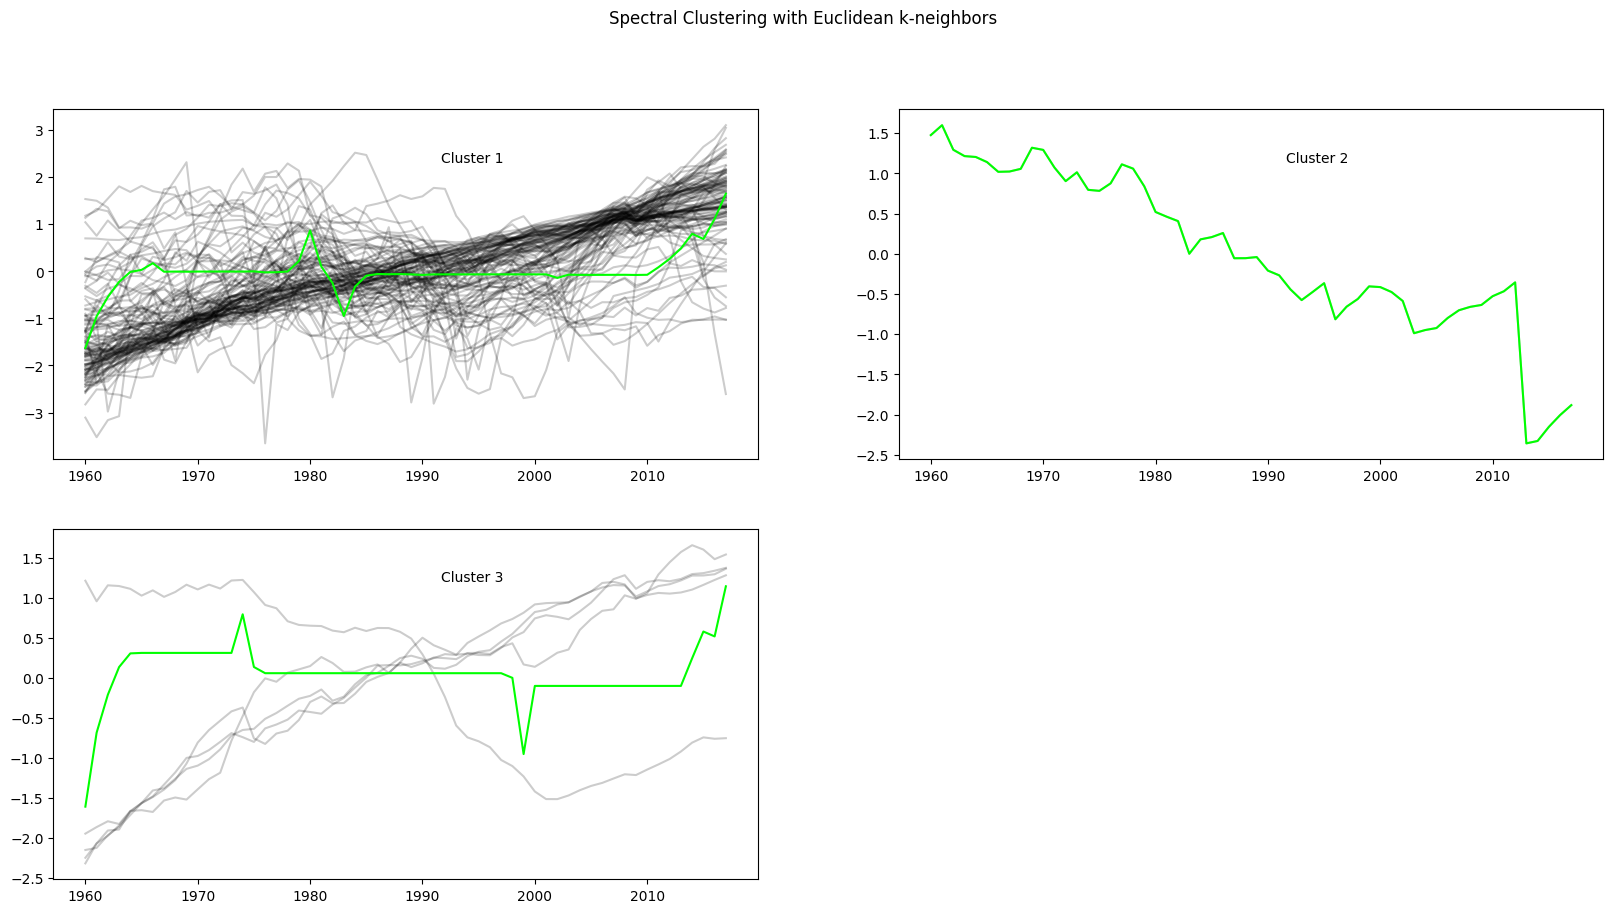

In [9]:
labels_knn = SpectralClustering.kmeans(
    H_knn, 3
)

score_knn = silhouette_score(scaled_data_gdp, labels_knn)
cluster_centers_knn = TimeSeriesUtils.cluster_centroids(scaled_data_gdp, 3, labels_knn, T_currency)
clusters = VisualUtils.show_clustering(
    names, 
    3, 
    scaled_data_gdp, 
    cluster_centers_knn, 
    labels_knn, 
    score_knn, 
    2, 
    2, 
    start_year, 
    T_currency, 
    "Spectral Clustering with Euclidean k-neighbors"
)

### $\epsilon$-neighborhood graph:

In order for the similarity graph to be sparse, we set $\epsilon$ to the 10th percentile of the distances.

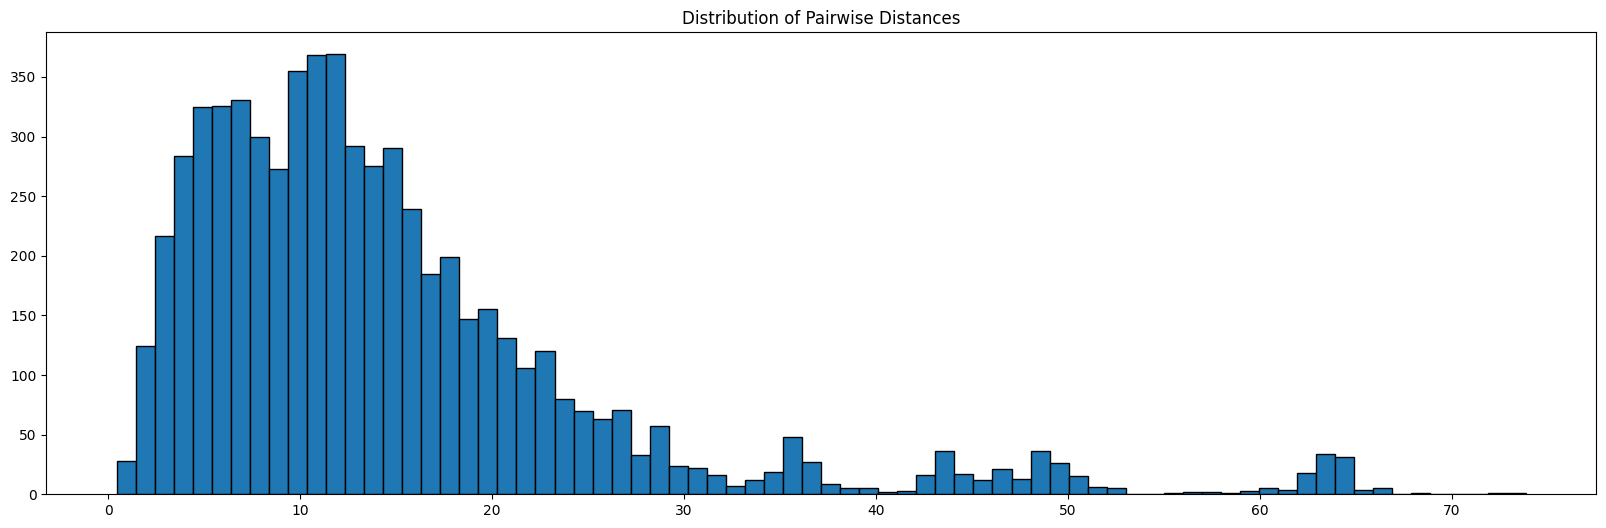

epsilon = 4.337176308344732


In [10]:
W_eps = SpectralClustering.epsilon_graph(
    scaled_df, 10, True
)

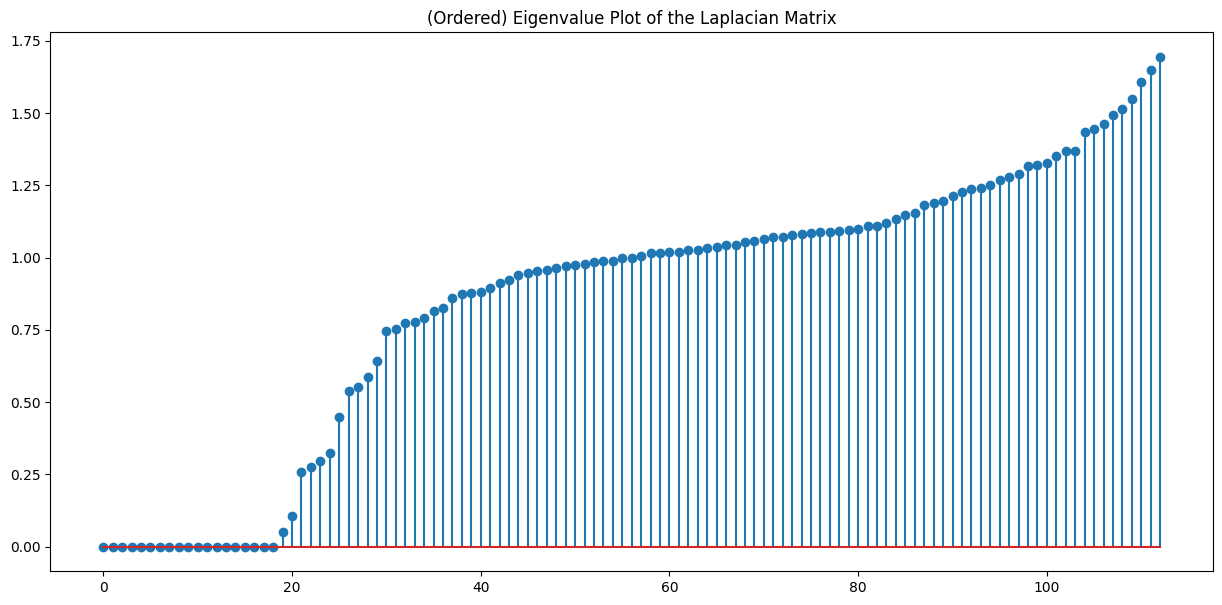

In [11]:
eigvals_eps_norm, eigvecs_eps_norm = SpectralClustering.laplacian_eigen(
    n, W_eps, True, True
)

We conclude 21 clusters are sufficient. We create the H matrix:

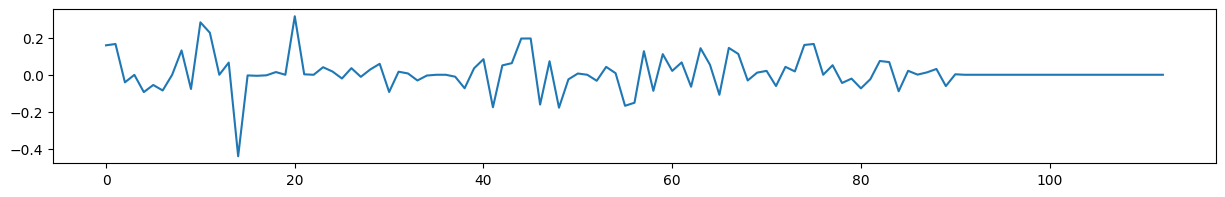

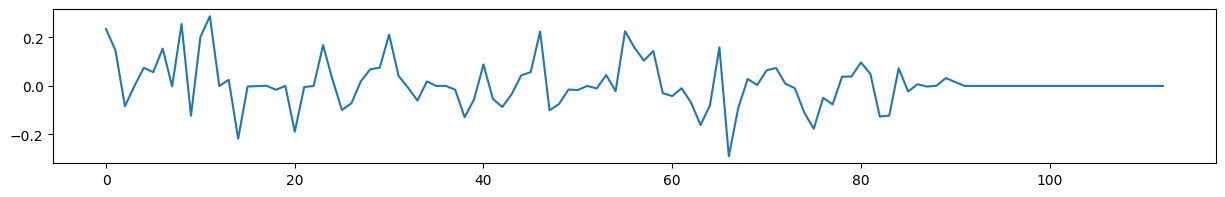

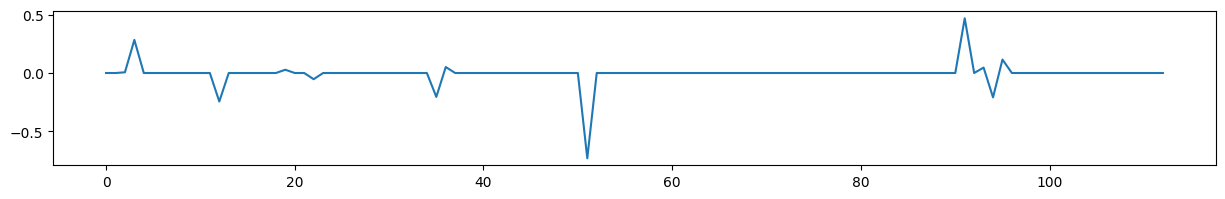

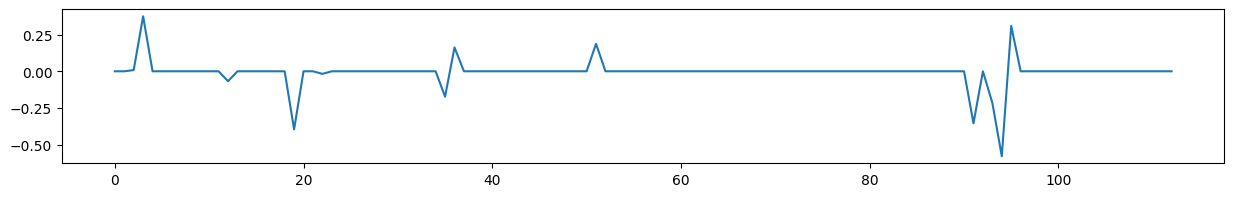

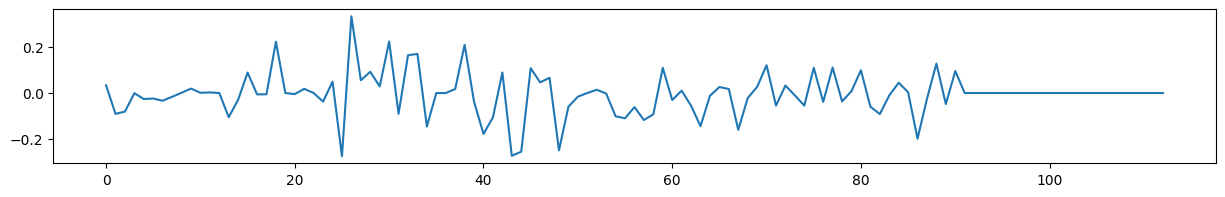

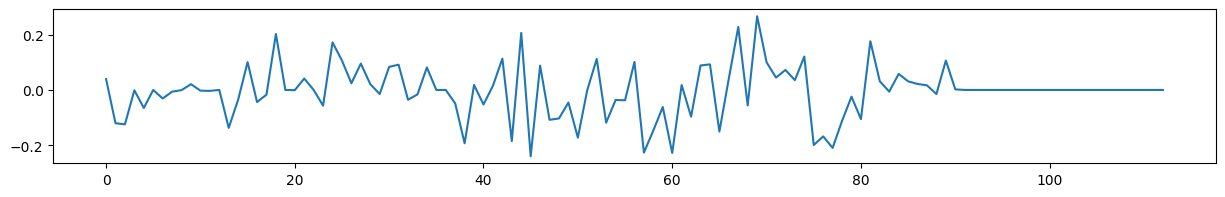

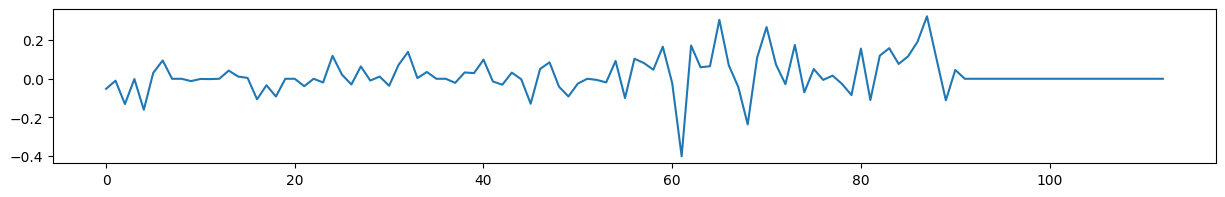

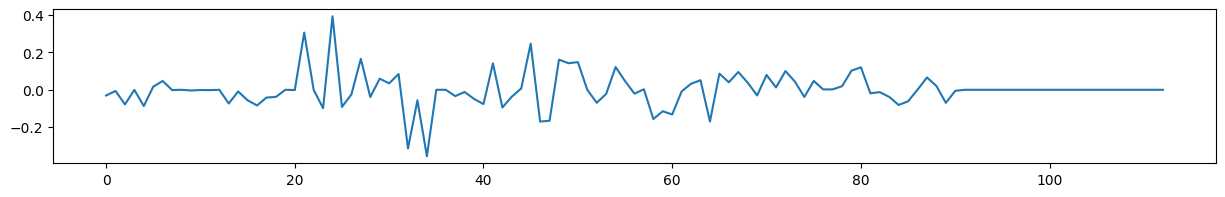

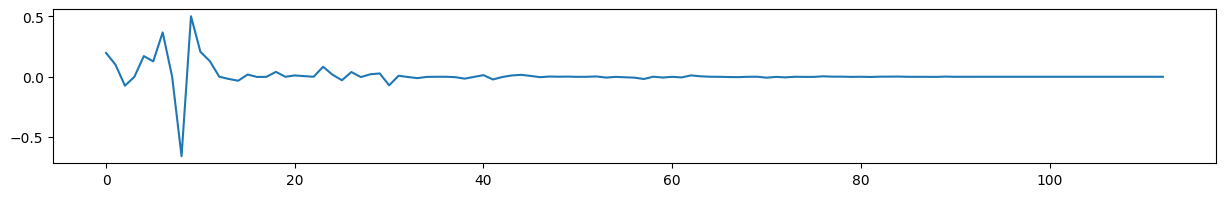

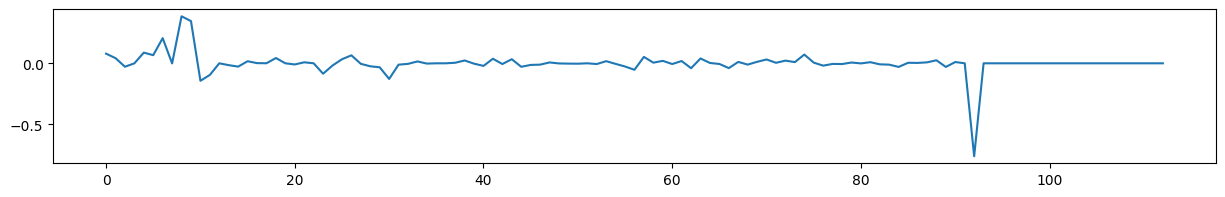

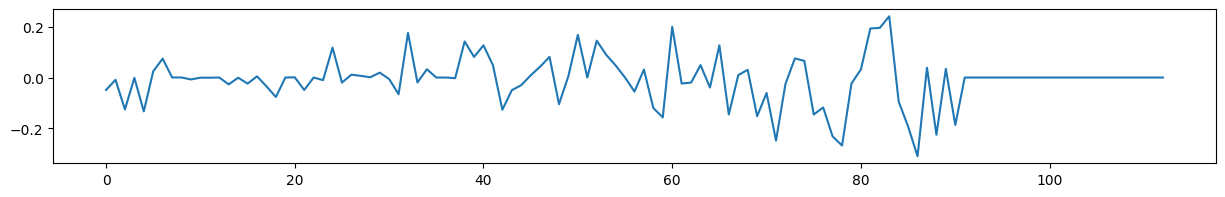

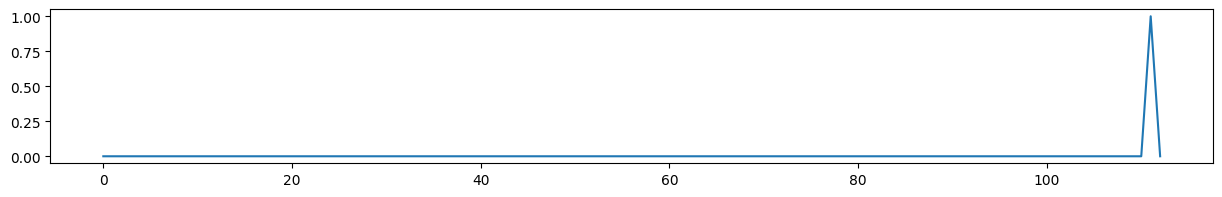

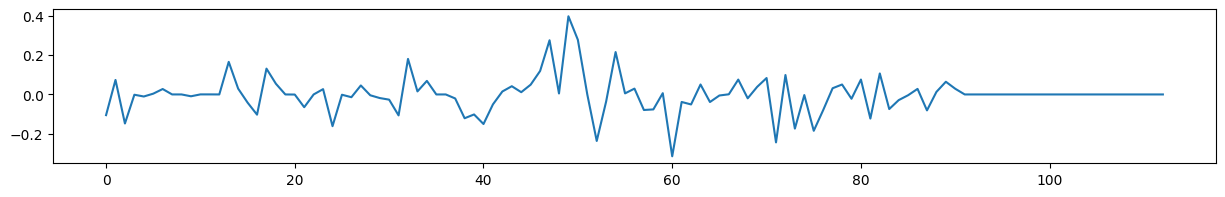

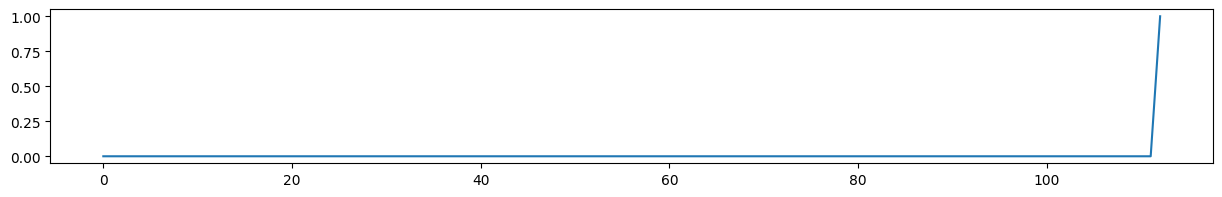

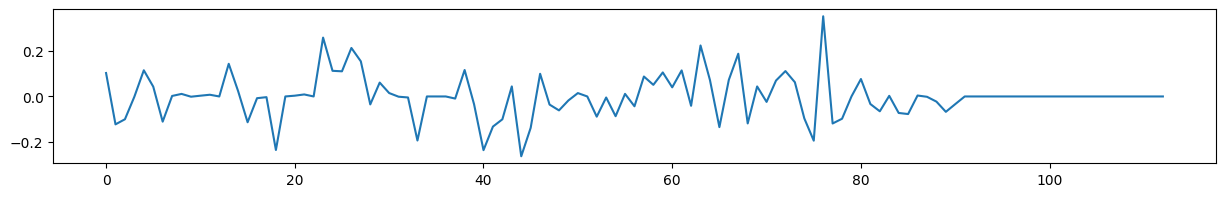

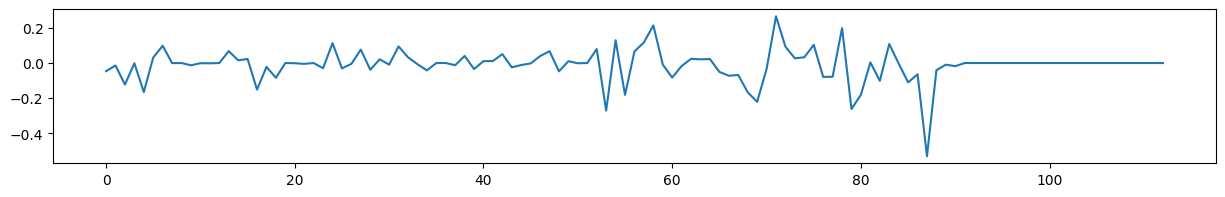

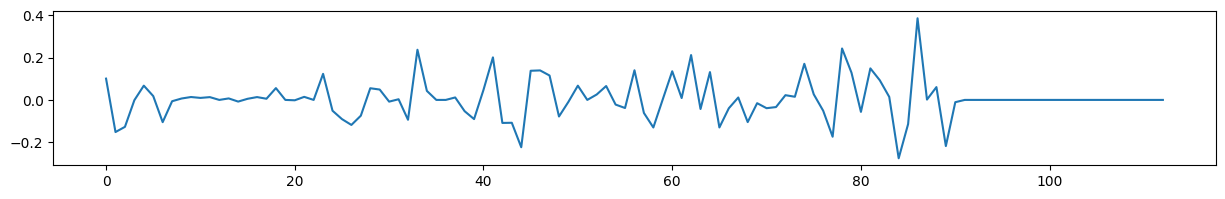

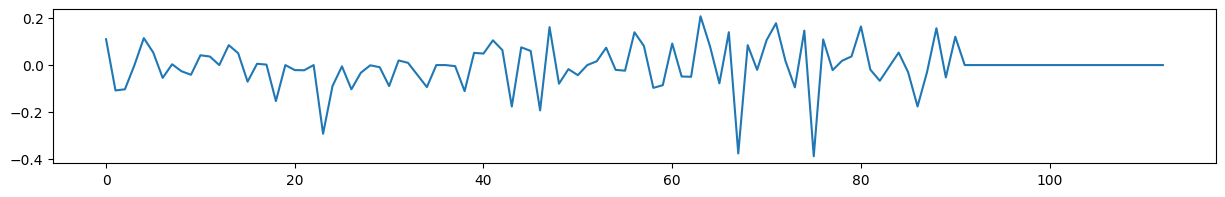

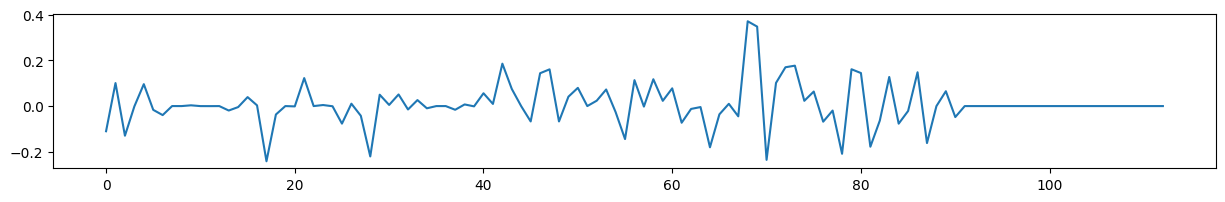

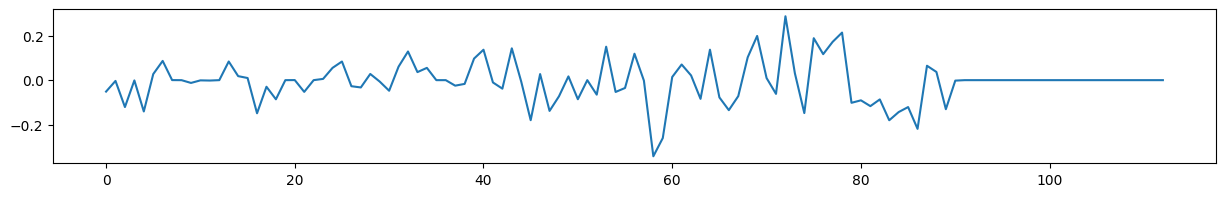

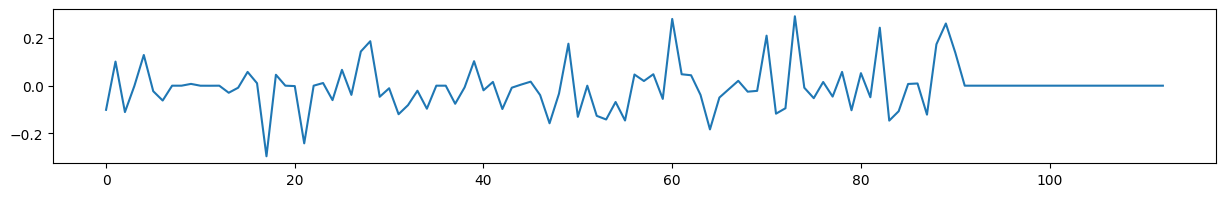

In [12]:
K_eps = 21
H_eps = SpectralClustering.smallest_eigenvecs(
    n, K_eps, eigvals_eps_norm, eigvecs_eps_norm, True
)

Two different eigenvectors give no information, so we can reduce the number of clusters to 19:

Silhouette Score: -0.5833901874016572
Cluster #1 size: 61
Cluster #1 members: AUS, AUT, BDI, BEN, BGD, CAF, CAN, CHE, CHN, CIV, COG, CRI, DEU, DOM, ESP, FIN, GHA, GIN, GRC, GTM, HKG, HND, HRV, HTI, IDN, ISR, KEN, LAO, LBR, LKA, MAR, MEX, MLI, MMR, MNG, MOZ, MRT, NIC, NPL, OMN, POL, PRT, PRY, PSE, ROU, SWE, SYR, TCD, TGO, THA, TUN, TUR, TWN, TZA, UGA, URY, USA, VEN, VNM, YEM, ZAF
Cluster #2 size: 5
Cluster #2 members: IRL, IRQ, ITA, JOR, KOR
Cluster #3 size: 1
Cluster #3 members: ZMB
Cluster #4 size: 1
Cluster #4 members: ZWE
Cluster #5 size: 3
Cluster #5 members: ARG, BOL, BRA
Cluster #6 size: 1
Cluster #6 members: SLE
Cluster #7 size: 12
Cluster #7 members: CHL, CMR, DZA, ETH, FRA, GBR, HUN, IRN, LBN, NER, NLD, SDN
Cluster #8 size: 1
Cluster #8 members: JPN
Cluster #9 size: 6
Cluster #9 members: BEL, COL, KHM, MYS, PER, PHL
Cluster #10 size: 1
Cluster #10 members: BGR
Cluster #11 size: 2
Cluster #11 members: BFA, BIH
Cluster #12 size: 4
Cluster #12 members: COD, SGP, SLV, SRB
Cluster 

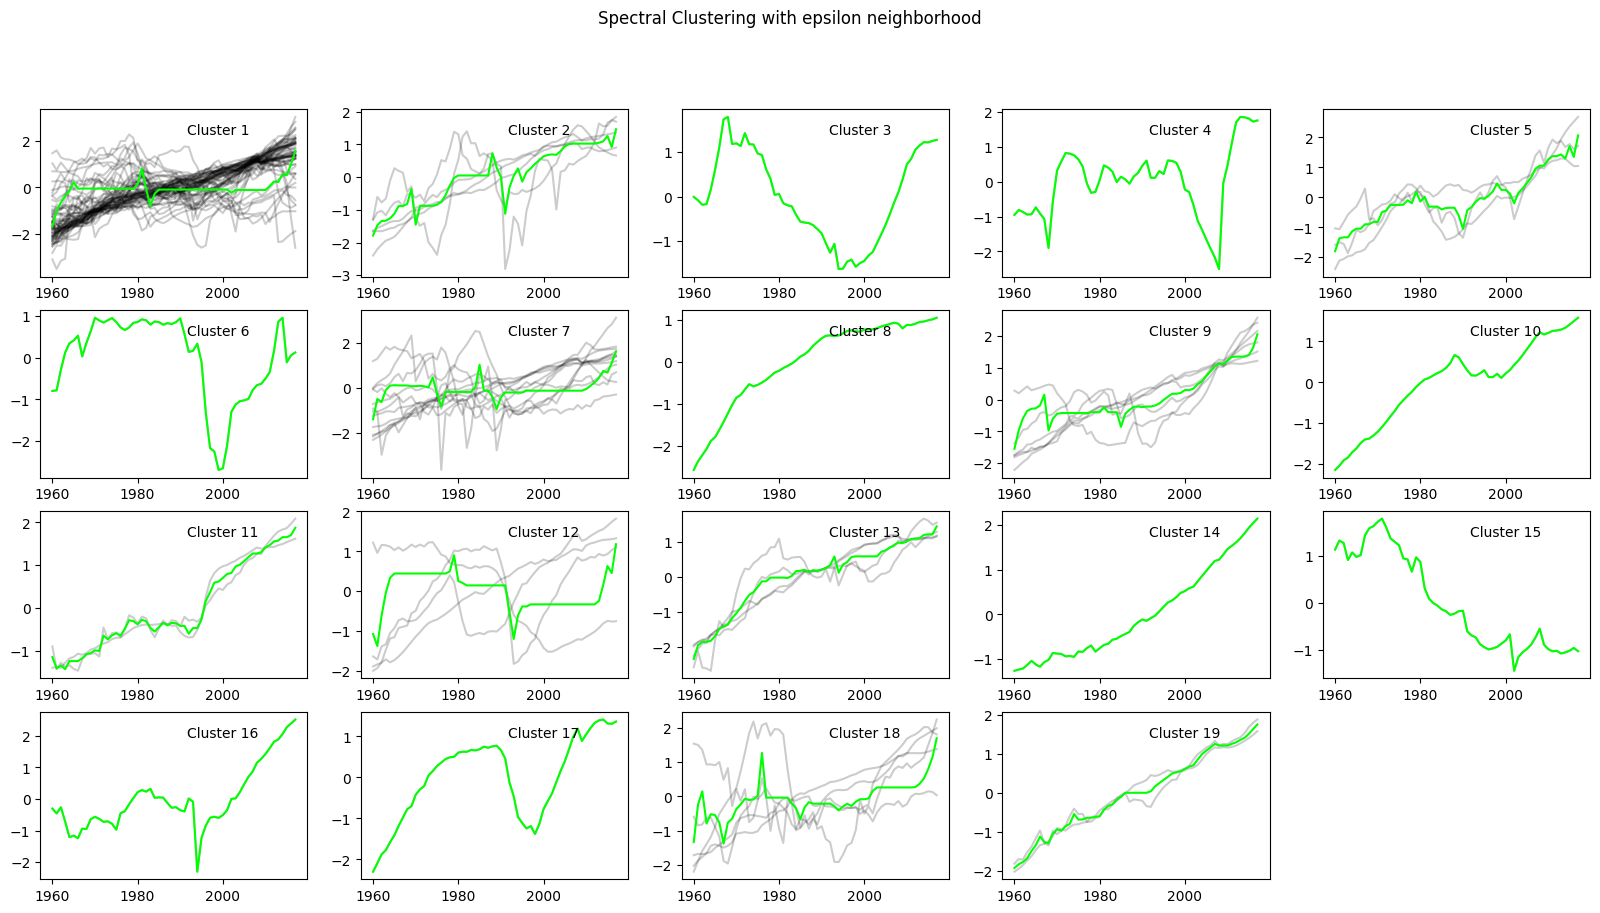

In [13]:
labels_eps = SpectralClustering.kmeans(
    H_eps, K_eps-2
)
score_eps = silhouette_score(scaled_data_gdp, labels_eps)
cluster_centers_eps = TimeSeriesUtils.cluster_centroids(scaled_data_gdp, K_eps-2, labels_eps, T_currency)
clusters = VisualUtils.show_clustering(
    names, 
    K_eps-2, 
    scaled_data_gdp, 
    cluster_centers_eps, 
    labels_eps, 
    score_eps, 
    4, 
    5, 
    start_year, 
    T_currency, 
    "Spectral Clustering with epsilon neighborhood"
)

### Spectral Clustering, Dynamic Time Warping and Kernel $k$-Means

Here, we construct a $k$-neighbors graph similar to the one before, but with a different distance measure. Instead of Euclidean Distance, Dynamic Time Warpint (DTW) is used to better capture the similaritites and differences of time series. Instead of the concatenated dataset, this section only considers the GDP time series, as it is the one of the highest significance and variance.

As suggested by previous work, this version of spectral clustering can provide an initial partition to be used for spectral clustering. For this reason, we have predetermined the number of clusters to 6, as this is the optimal number of clusters for kernel k-means according to the elbow plot heuristic. We can see, however, that the eigenvalue plot indicates 6 is a reasonable choice, as there is a clear gap between the 6th and 7th smallest eigenvalues, and all 6 corresonding eigenvectors are informative. 

In [14]:
W_dtw = SpectralClustering.dtw_knn_graph(n, scaled_df_gdp)

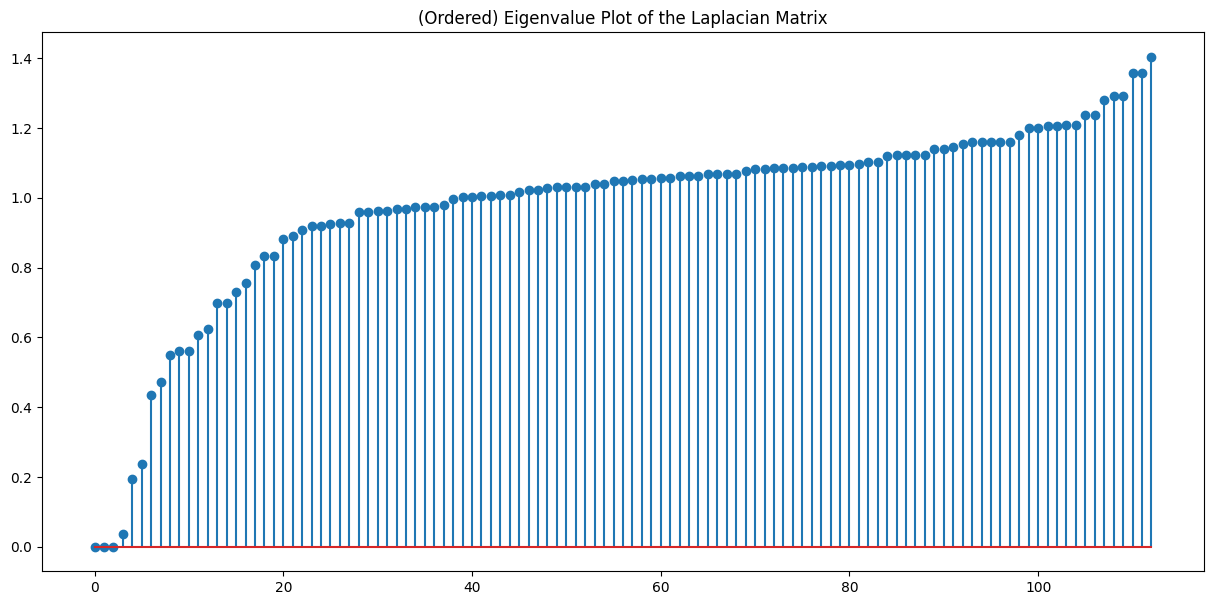

In [15]:
eigvals_dtw_norm, eigvecs_dtw_norm = SpectralClustering.laplacian_eigen(
    n, W_dtw, True, True
)

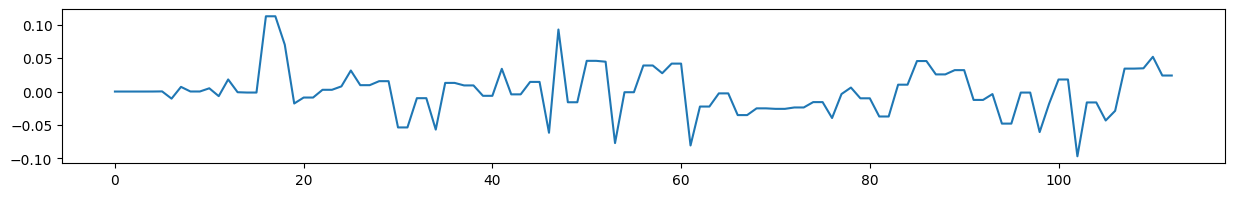

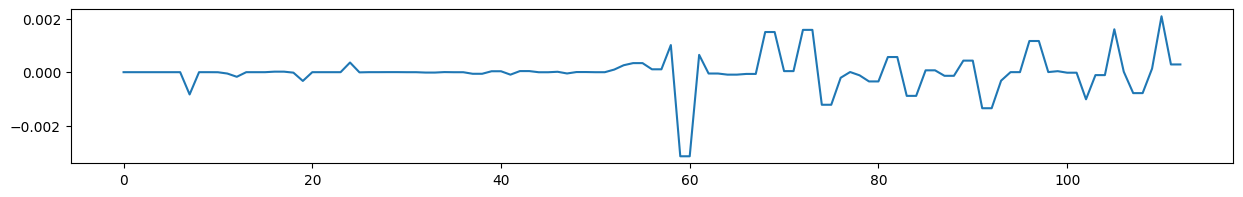

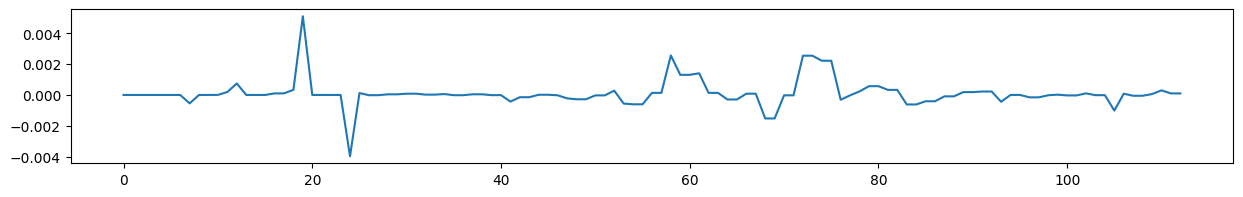

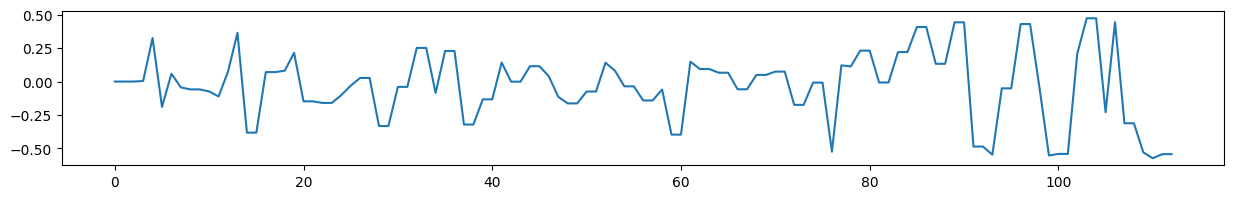

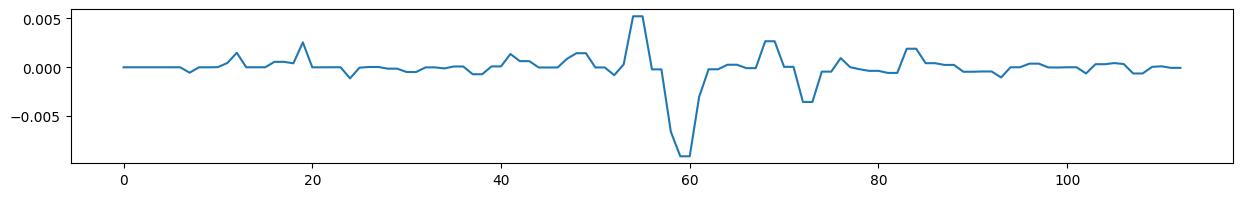

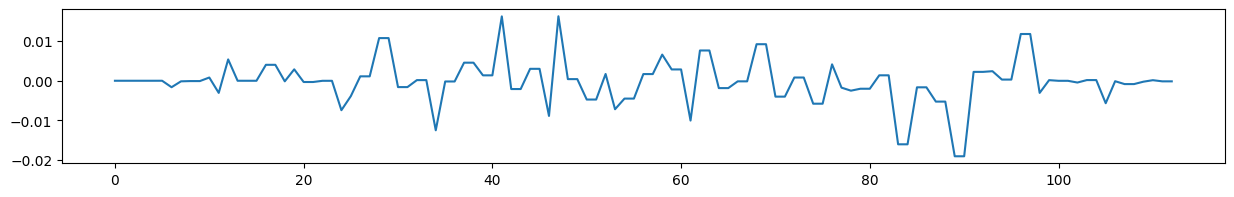

In [16]:
K_dtw = 6
H_dtw = SpectralClustering.smallest_eigenvecs(
    n, K_dtw, eigvals_dtw_norm, eigvecs_dtw_norm, True
)

Silhouette Score: -0.1063483063145792
Cluster #1 size: 11
Cluster #1 members: CHE, CHL, EGY, ESP, GTM, HKG, MAR, MDG, URY, VEN, VNM
Cluster #2 size: 15
Cluster #2 members: COD, FRA, GBR, GIN, GRC, HTI, KEN, MEX, PER, PHL, PRY, PSE, RWA, SAU, TWN
Cluster #3 size: 31
Cluster #3 members: ARG, AUS, AUT, BDI, BFA, CAF, CHN, CIV, CMR, DZA, ECU, HUN, IDN, IND, IRL, IRN, KHM, MLI, MMR, MNG, MOZ, MYS, NER, NGA, NIC, NPL, NZL, PAK, PAN, POL, PRT
Cluster #4 size: 34
Cluster #4 members: BEN, BGD, BGR, BIH, BOL, BRA, COG, COL, CRI, DEU, DNK, DOM, ETH, FIN, GHA, HND, HRV, IRQ, ISR, ITA, JOR, JPN, KOR, LAO, LBN, LBR, LKA, MRT, MWI, NLD, NOR, SRB, SWE, TGO
Cluster #5 size: 11
Cluster #5 members: BEL, CAN, ROU, RUS, SDN, SEN, SYR, TCD, TZA, UGA, USA
Cluster #6 size: 11
Cluster #6 members: OMN, SGP, SLE, SLV, THA, TUN, TUR, YEM, ZAF, ZMB, ZWE


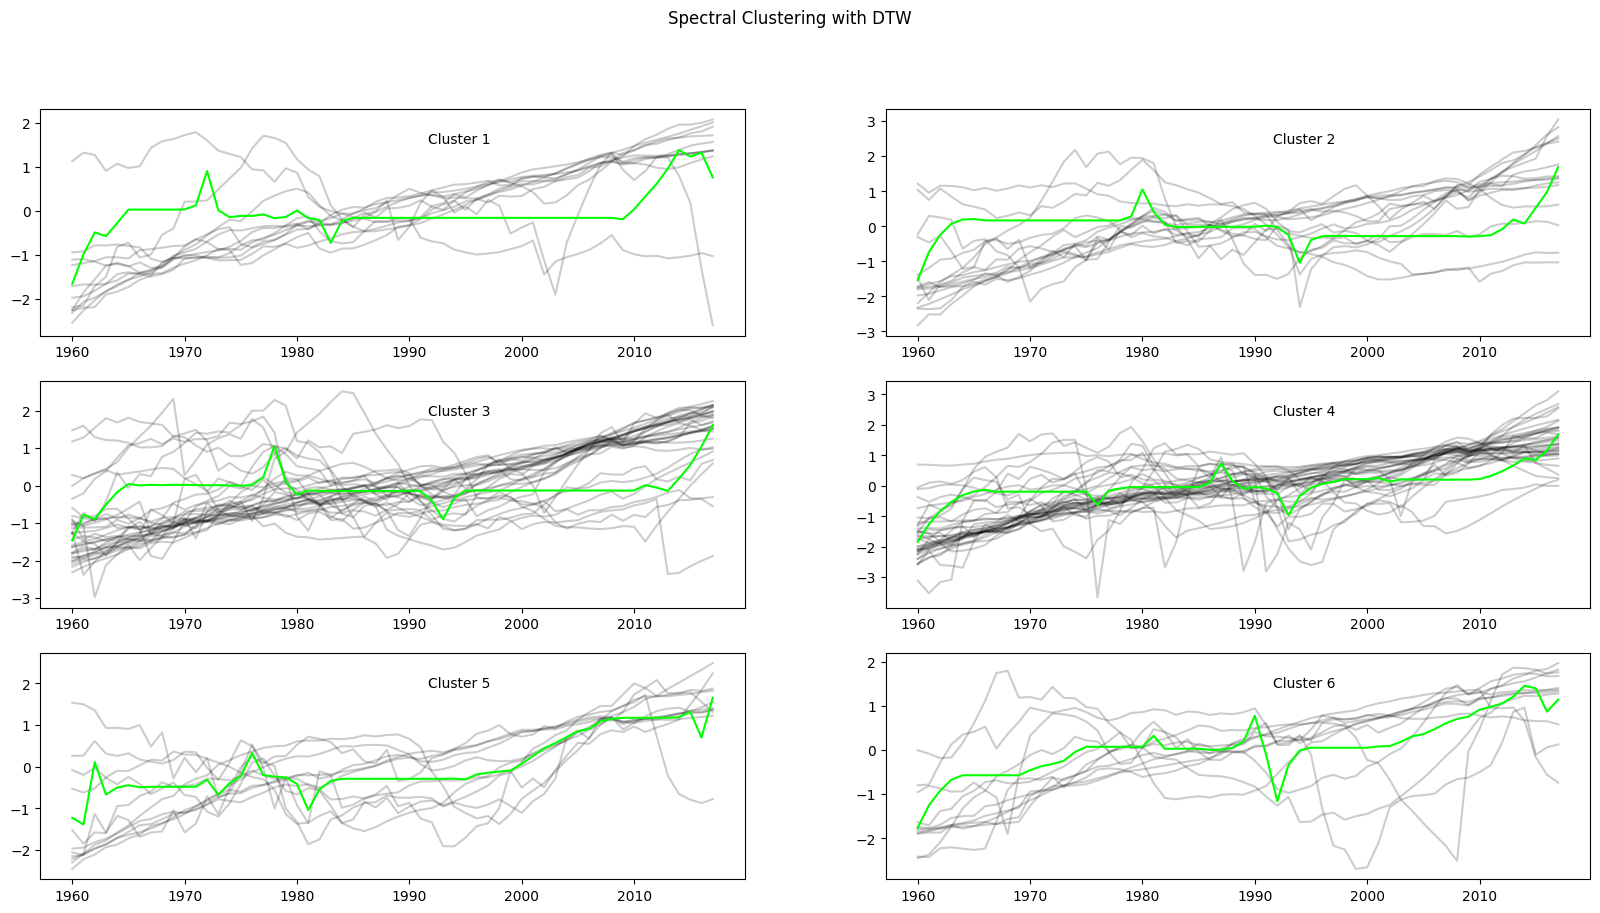

In [17]:
labels_dtw = SpectralClustering.kmeans(
    H_dtw, K_dtw
)

score_dtw = silhouette_score(scaled_data_gdp, labels_dtw)
cluster_centers_dtw = TimeSeriesUtils.cluster_centroids(scaled_data_gdp, K_dtw, labels_dtw, T_currency)
clusters = VisualUtils.show_clustering(
    names, 
    K_dtw, 
    scaled_data_gdp, 
    cluster_centers_dtw, 
    labels_dtw, 
    score_dtw, 
    3, 
    2, 
    start_year, 
    T_currency, 
    "Spectral Clustering with DTW"
)

Silhouette Score: 0.3289398587513227
Cluster #1 size: 68
Cluster #1 members: AUS, AUT, BEL, BEN, BFA, BGR, BIH, BRA, CAN, CHE, CHL, CHN, COG, COL, CRI, DEU, DNK, DOM, DZA, ECU, EGY, ESP, FIN, FRA, GBR, GRC, GTM, HKG, HND, HRV, HUN, IDN, IND, IRL, ISR, ITA, JPN, KOR, LAO, LKA, MAR, MEX, MLI, MNG, MYS, NLD, NOR, NPL, NZL, OMN, PAK, PAN, POL, PRT, PRY, PSE, ROU, SGP, SWE, SYR, THA, TUN, TUR, TWN, URY, USA, VNM, YEM
Cluster #2 size: 8
Cluster #2 members: CAF, CIV, COD, HTI, MDG, NER, SAU, TGO
Cluster #3 size: 17
Cluster #3 members: ARG, BGD, BOL, ETH, GIN, JOR, KEN, MMR, MOZ, NGA, PER, PHL, RWA, SDN, SLV, TZA, ZAF
Cluster #4 size: 9
Cluster #4 members: BDI, CMR, IRQ, MRT, MWI, RUS, SRB, VEN, ZWE
Cluster #5 size: 6
Cluster #5 members: GHA, KHM, LBN, SEN, TCD, UGA
Cluster #6 size: 5
Cluster #6 members: IRN, LBR, NIC, SLE, ZMB


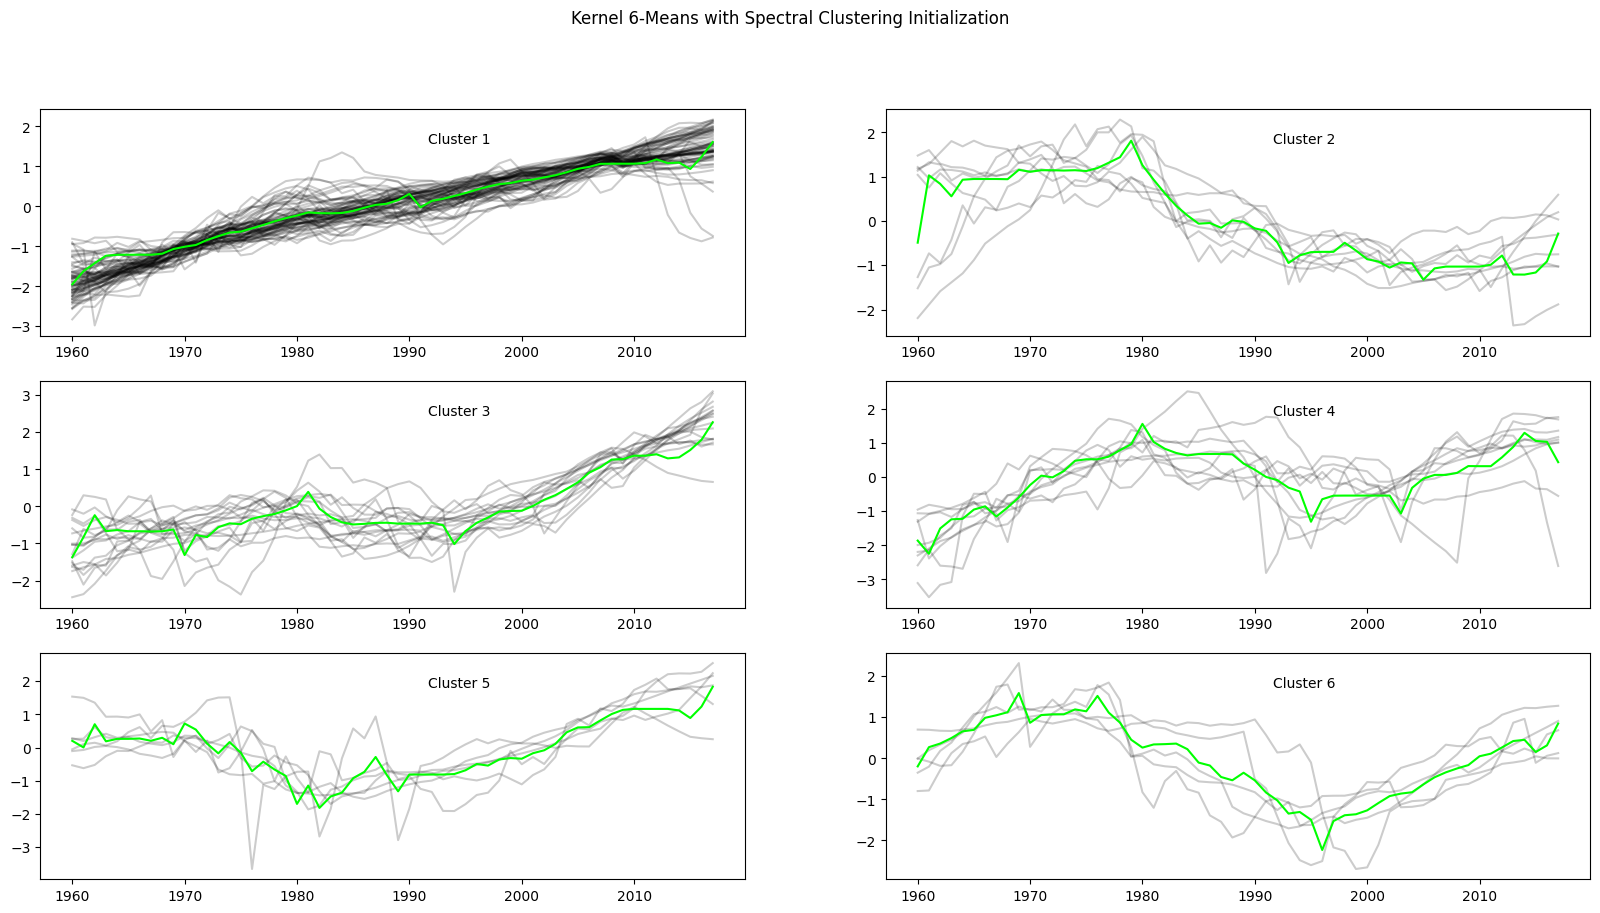

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    kkmeans = KernelKMeans.NonRandomKernelKMeans(6, labels_dtw)
    y_kkmeans = kkmeans.fit_predict(scaled_df_gdp)

score_kkmeans = silhouette_score(scaled_data_gdp, y_kkmeans)
cluster_centers_kkmeans = TimeSeriesUtils.cluster_centroids(scaled_data_gdp, K_dtw, y_kkmeans, T_currency)
clusters = VisualUtils.show_clustering(
    names, 
    K_dtw, 
    scaled_data_gdp, 
    cluster_centers_kkmeans, 
    y_kkmeans, 
    score_kkmeans, 
    3, 
    2, 
    start_year, 
    T_currency, 
    "Kernel 6-Means with Spectral Clustering Initialization"
)

This algorithm produces well-structured clusters and achieves a considerable silhouette score. We visualize the results on a map and we display how the clustering corresponds to commonly accepted groupings of countries

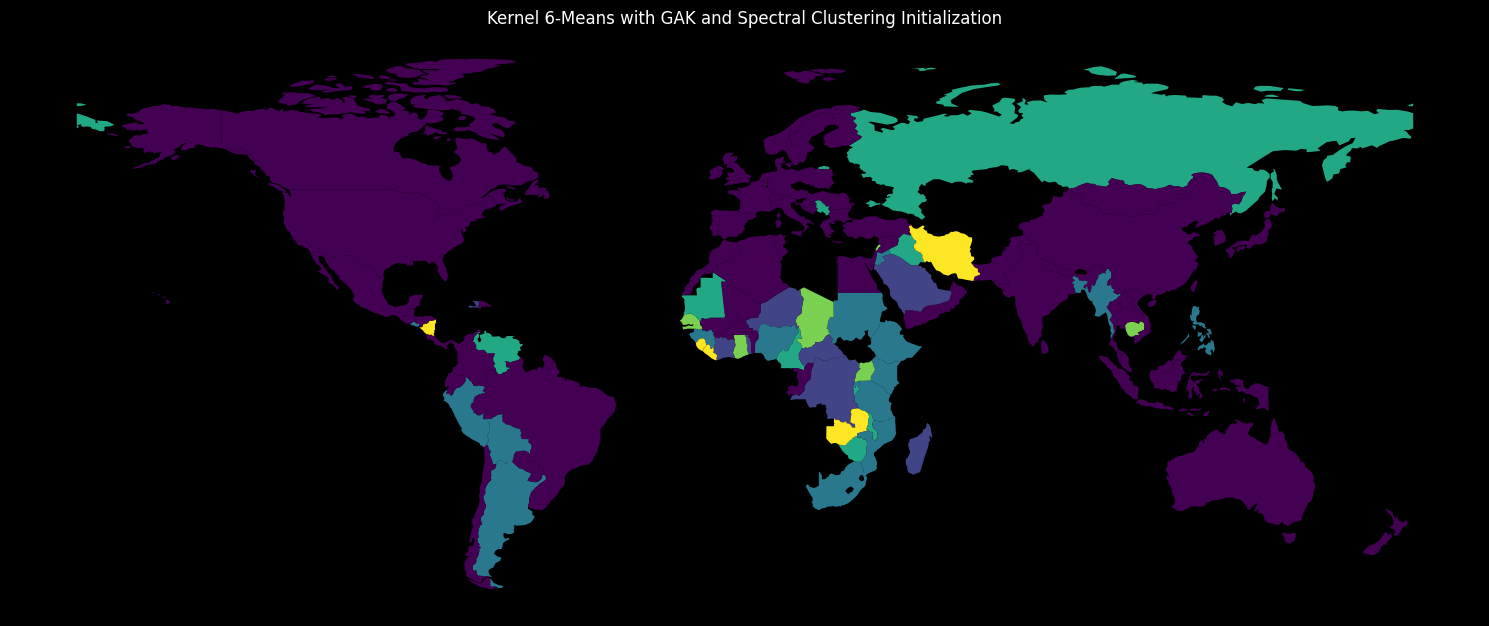

In [19]:
VisualUtils.show_clusters_on_map(names, y_kkmeans, map, 'Kernel 6-Means with GAK and Spectral Clustering Initialization')

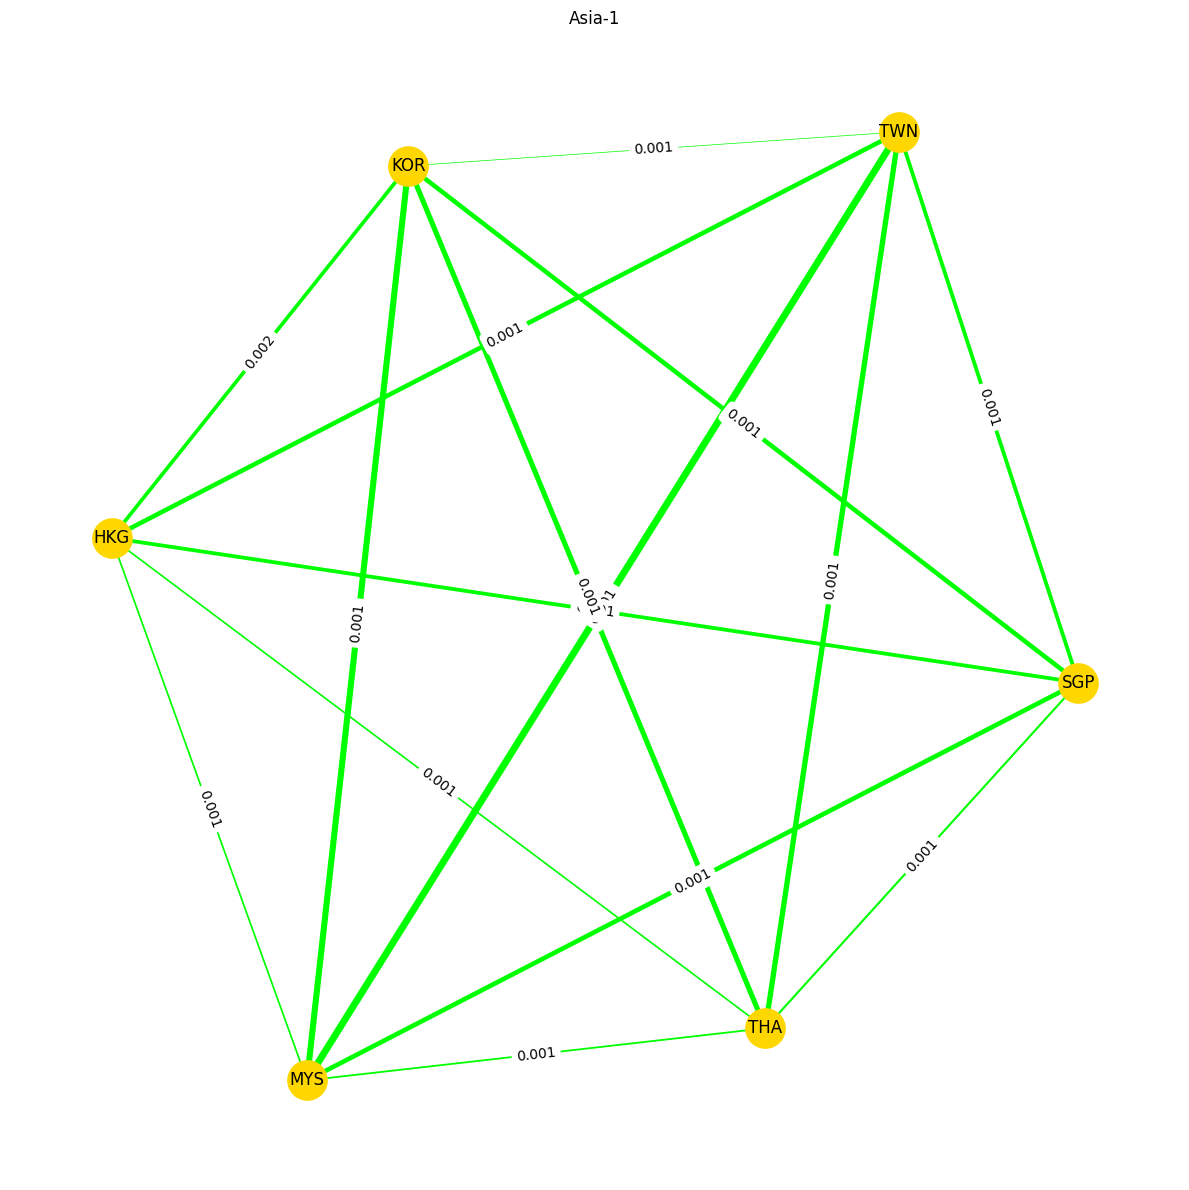

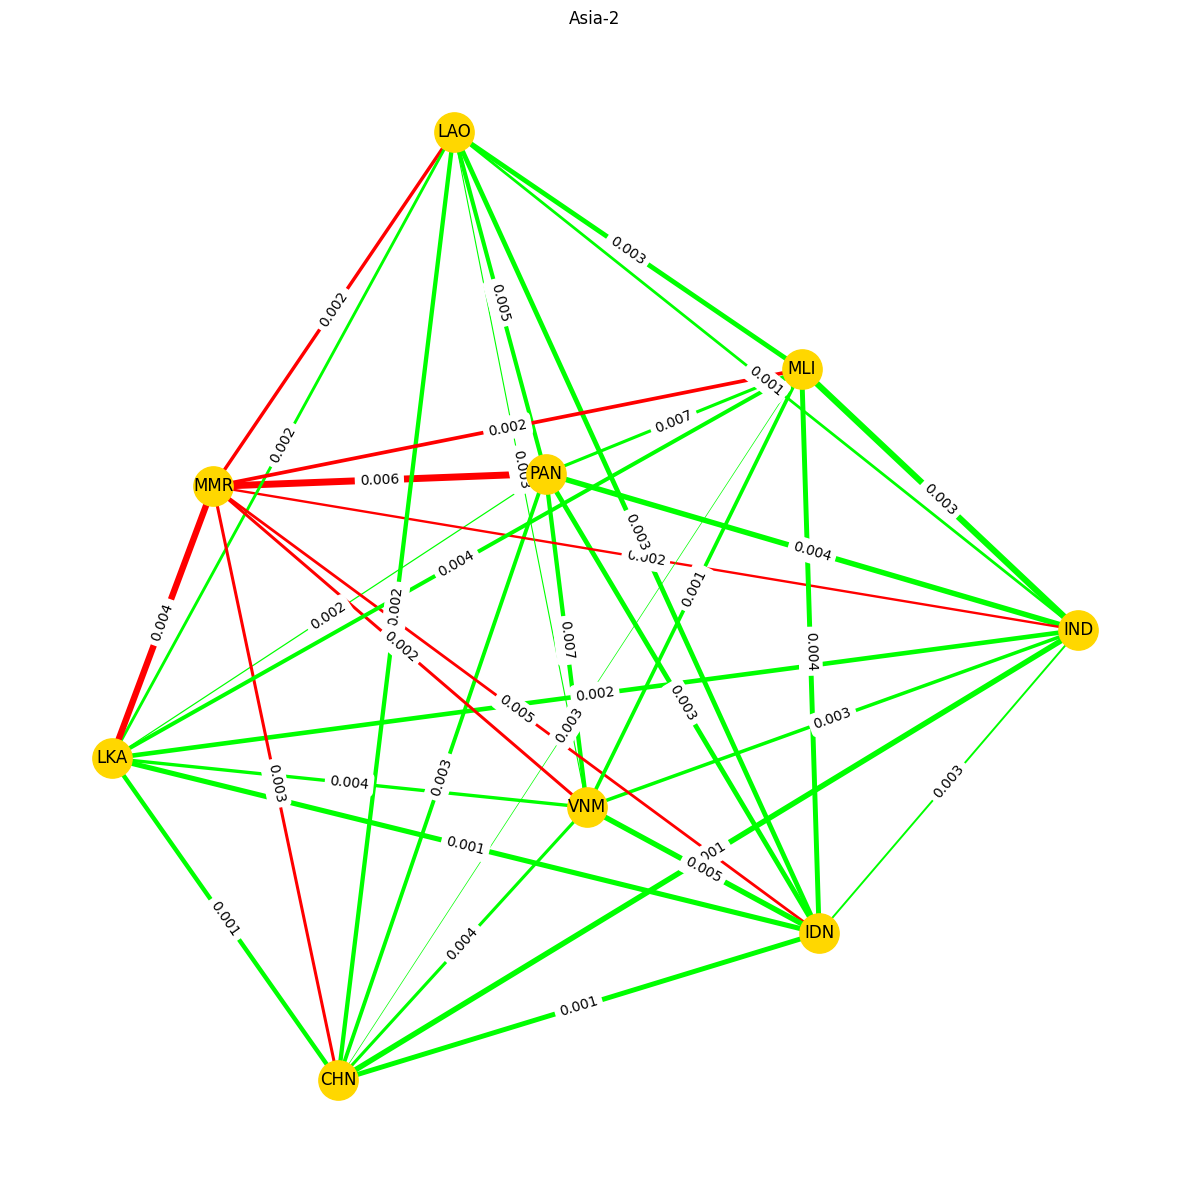

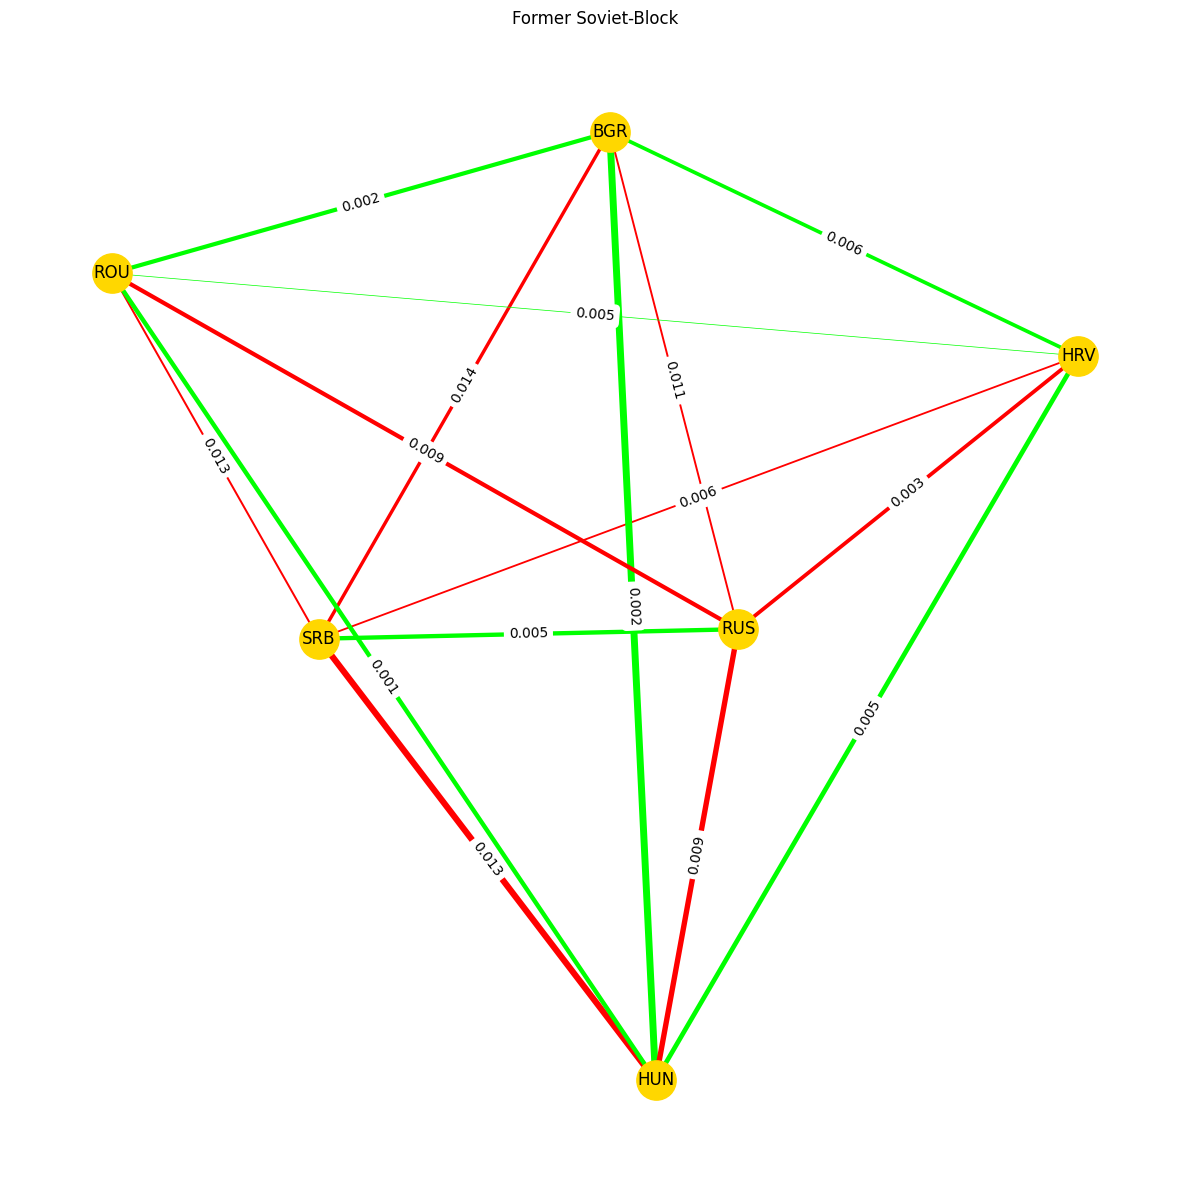

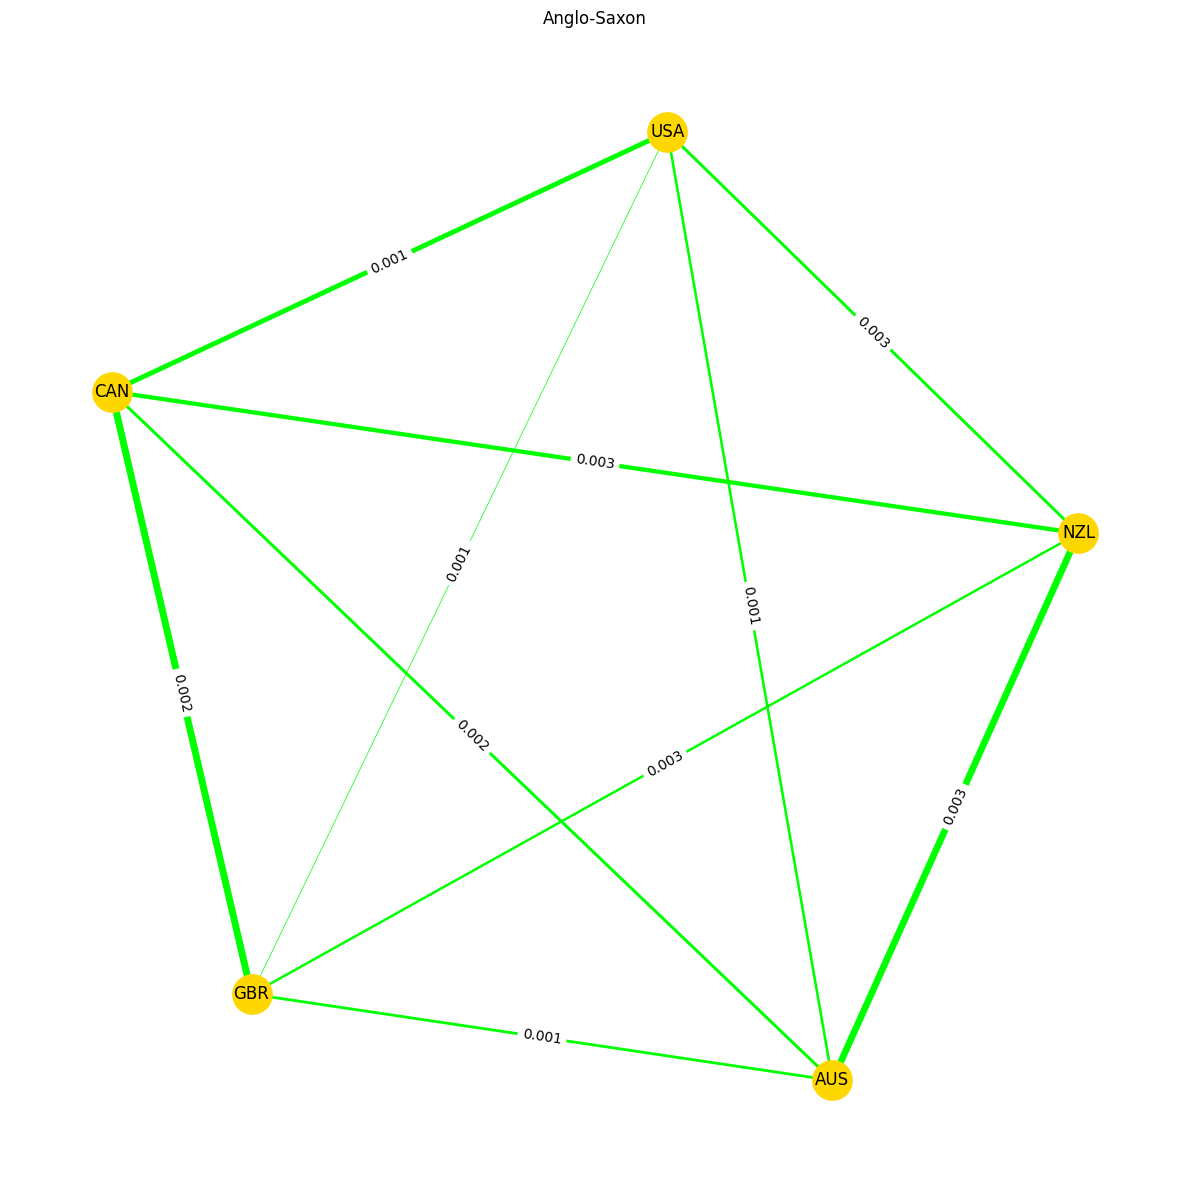

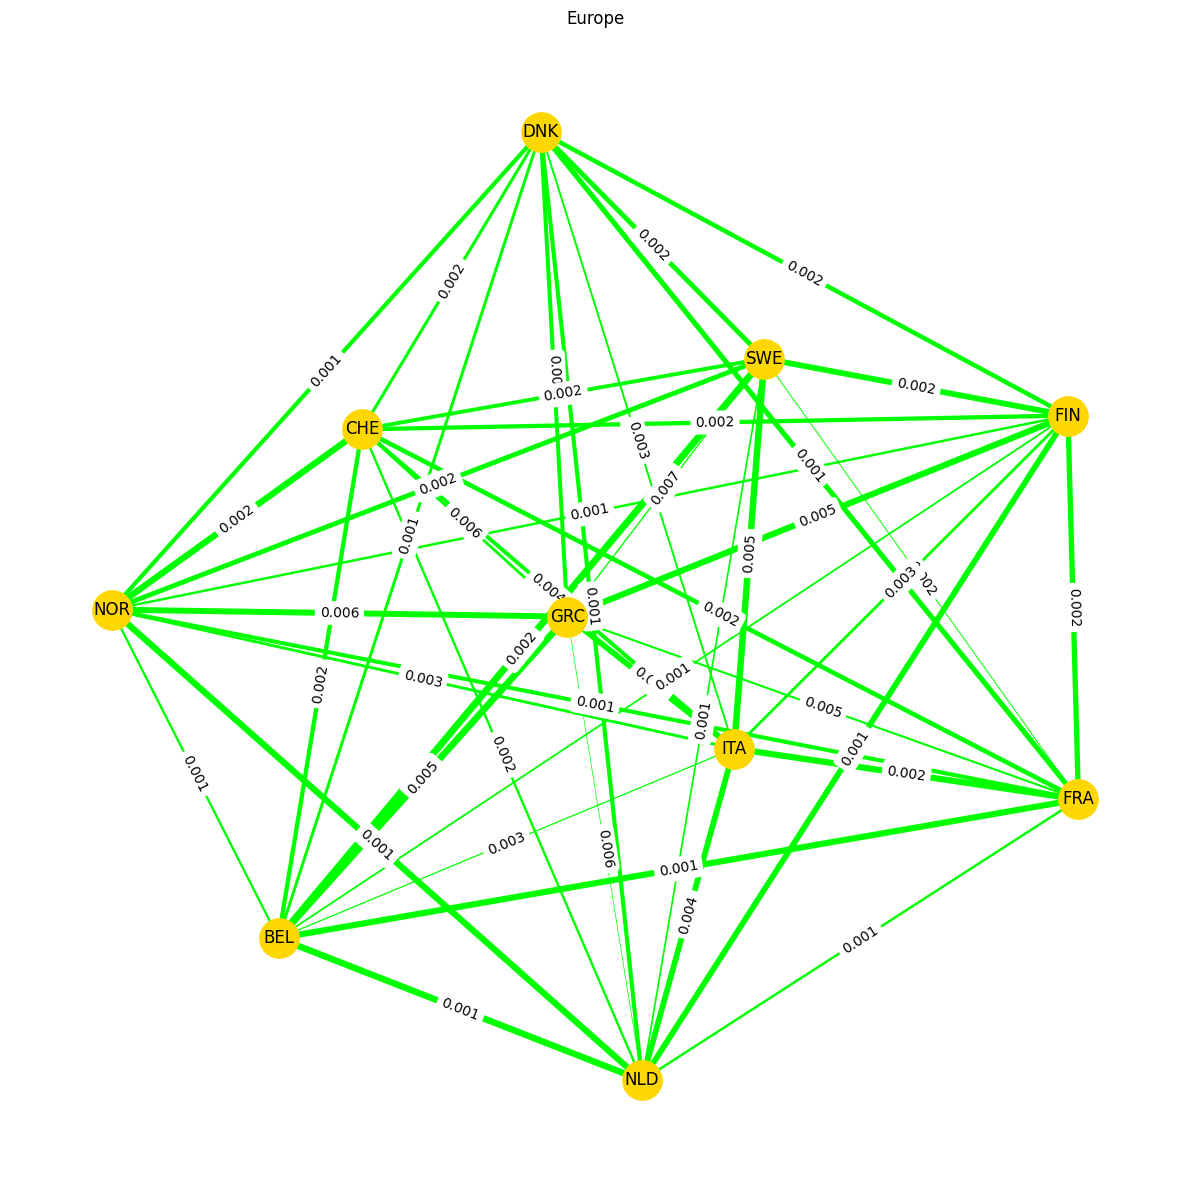

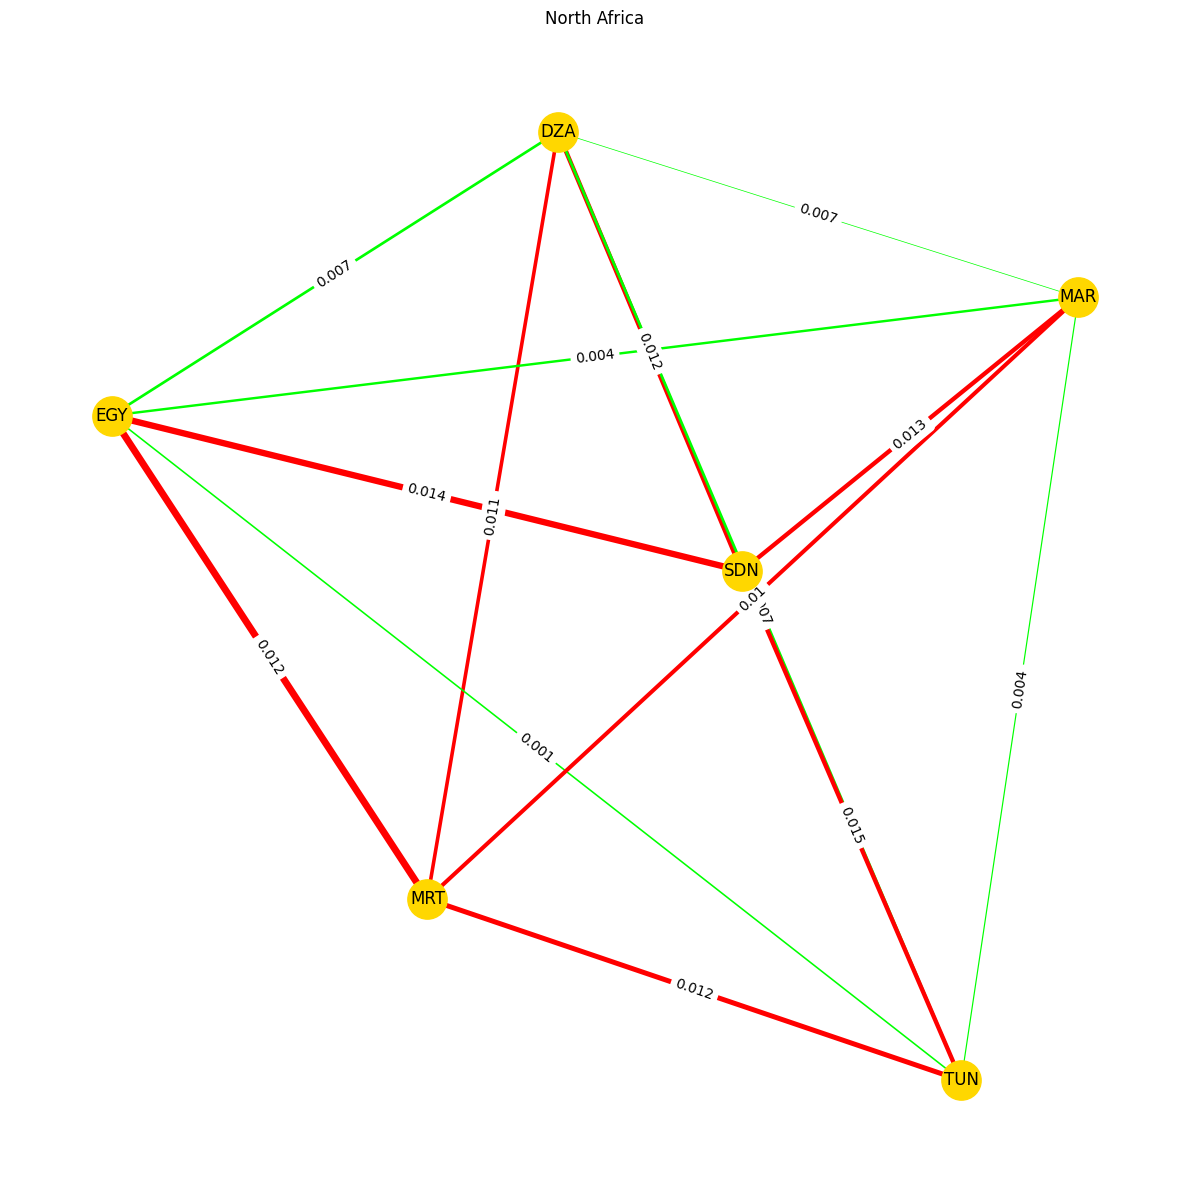

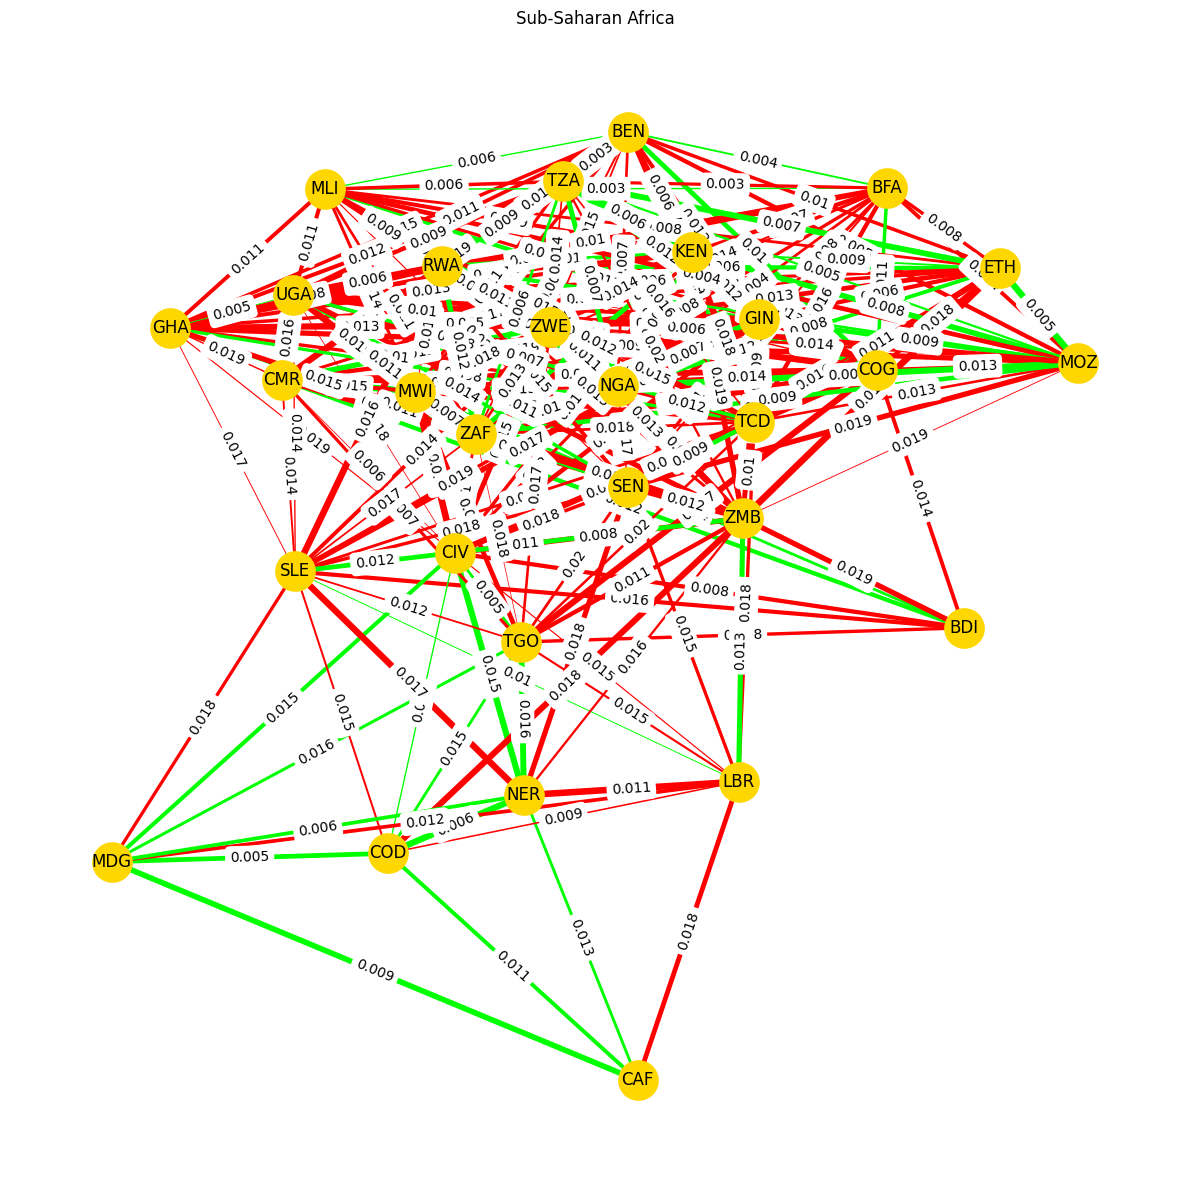

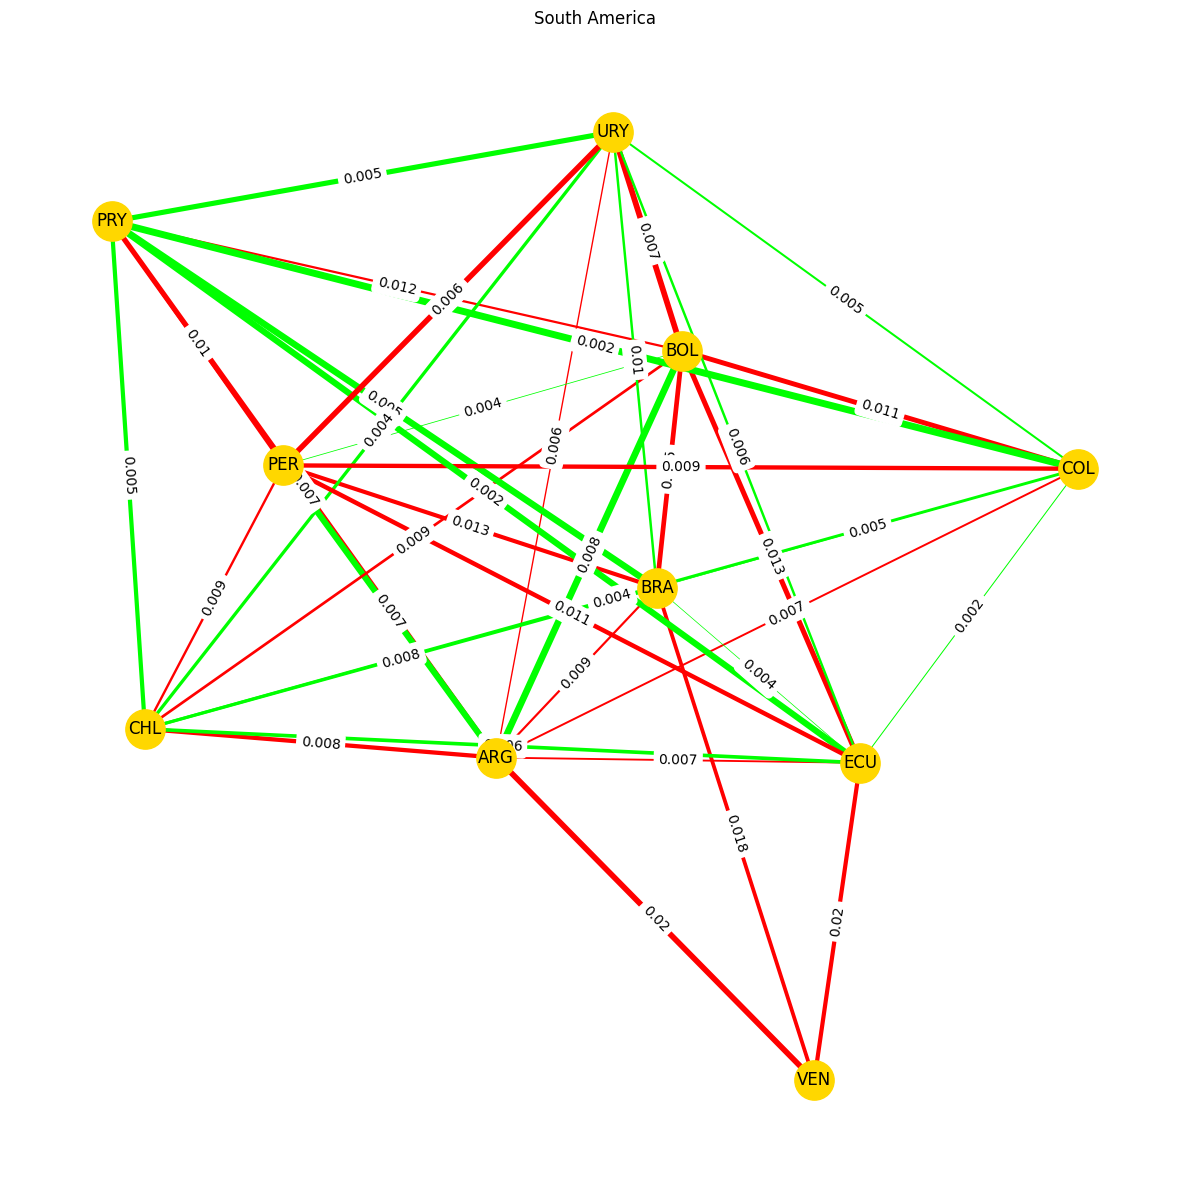

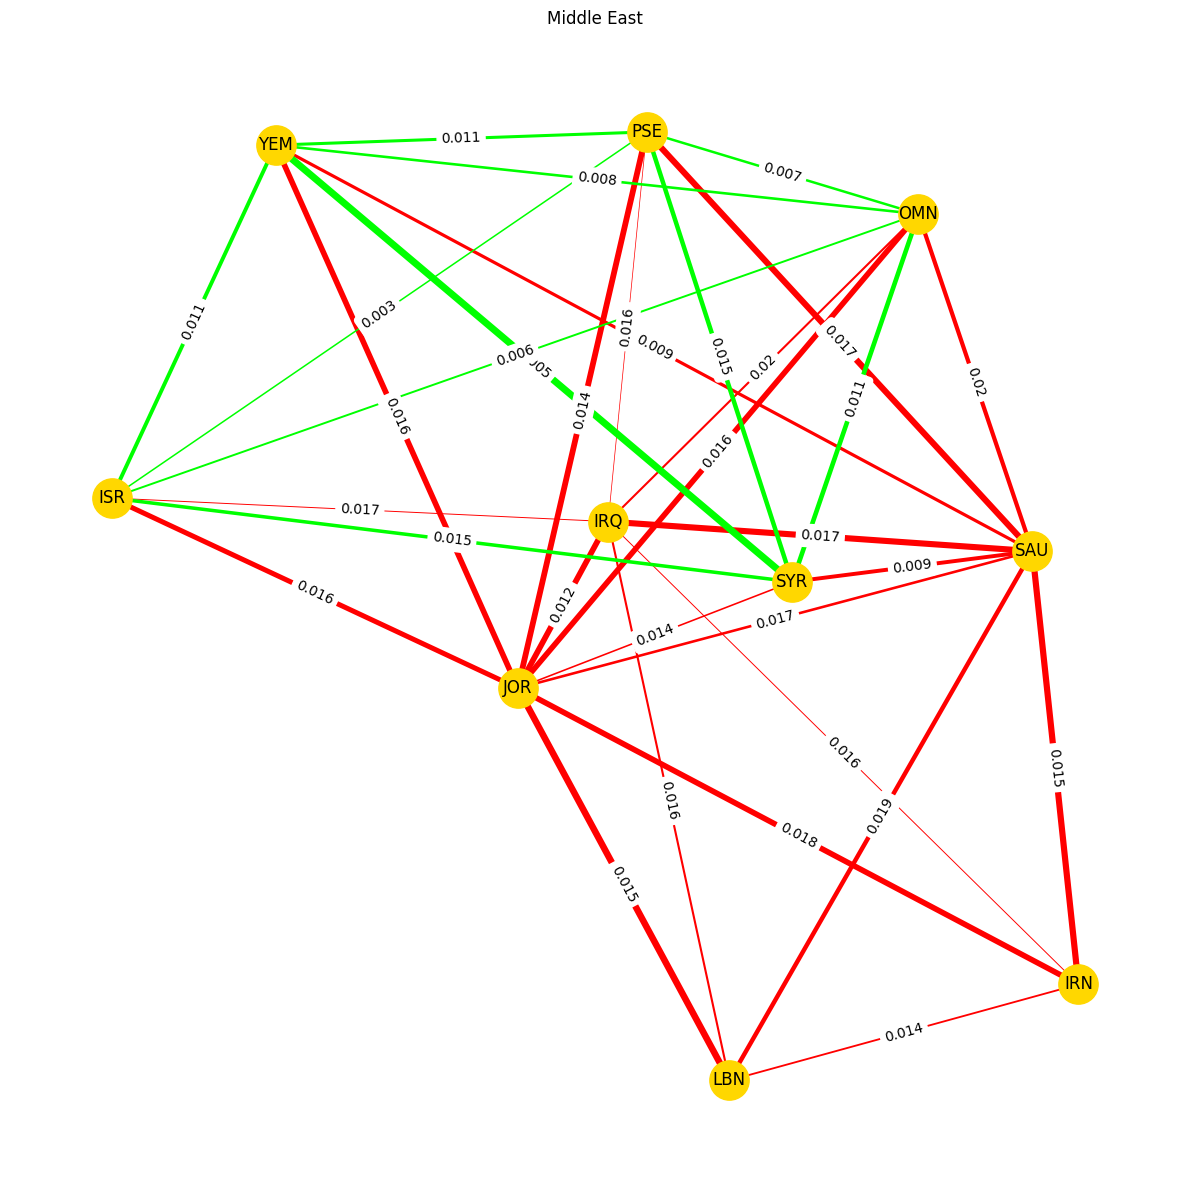

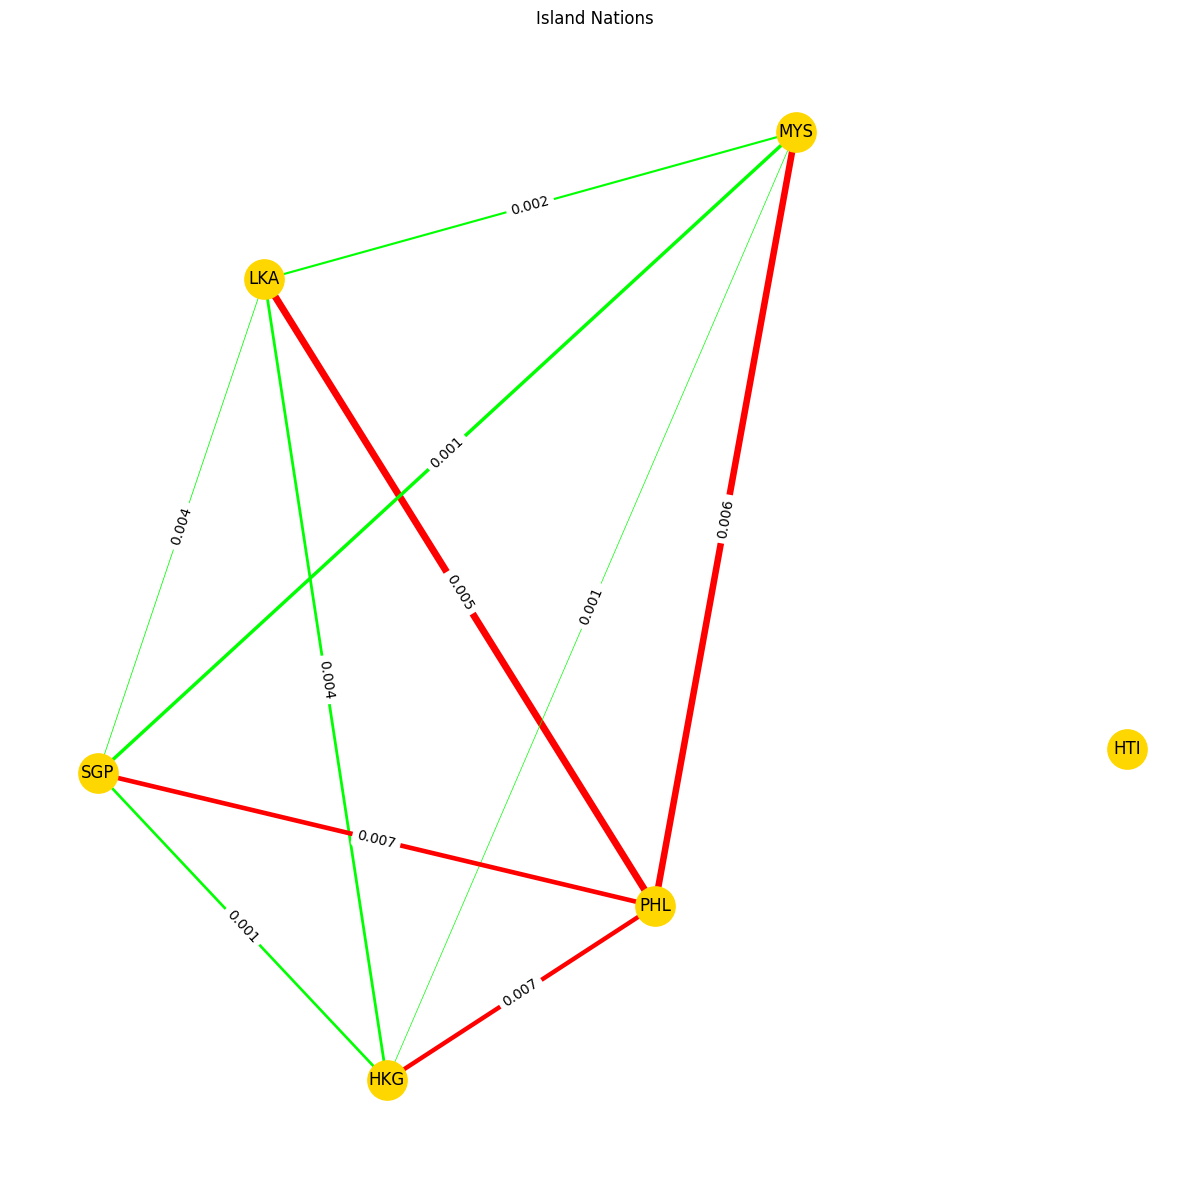

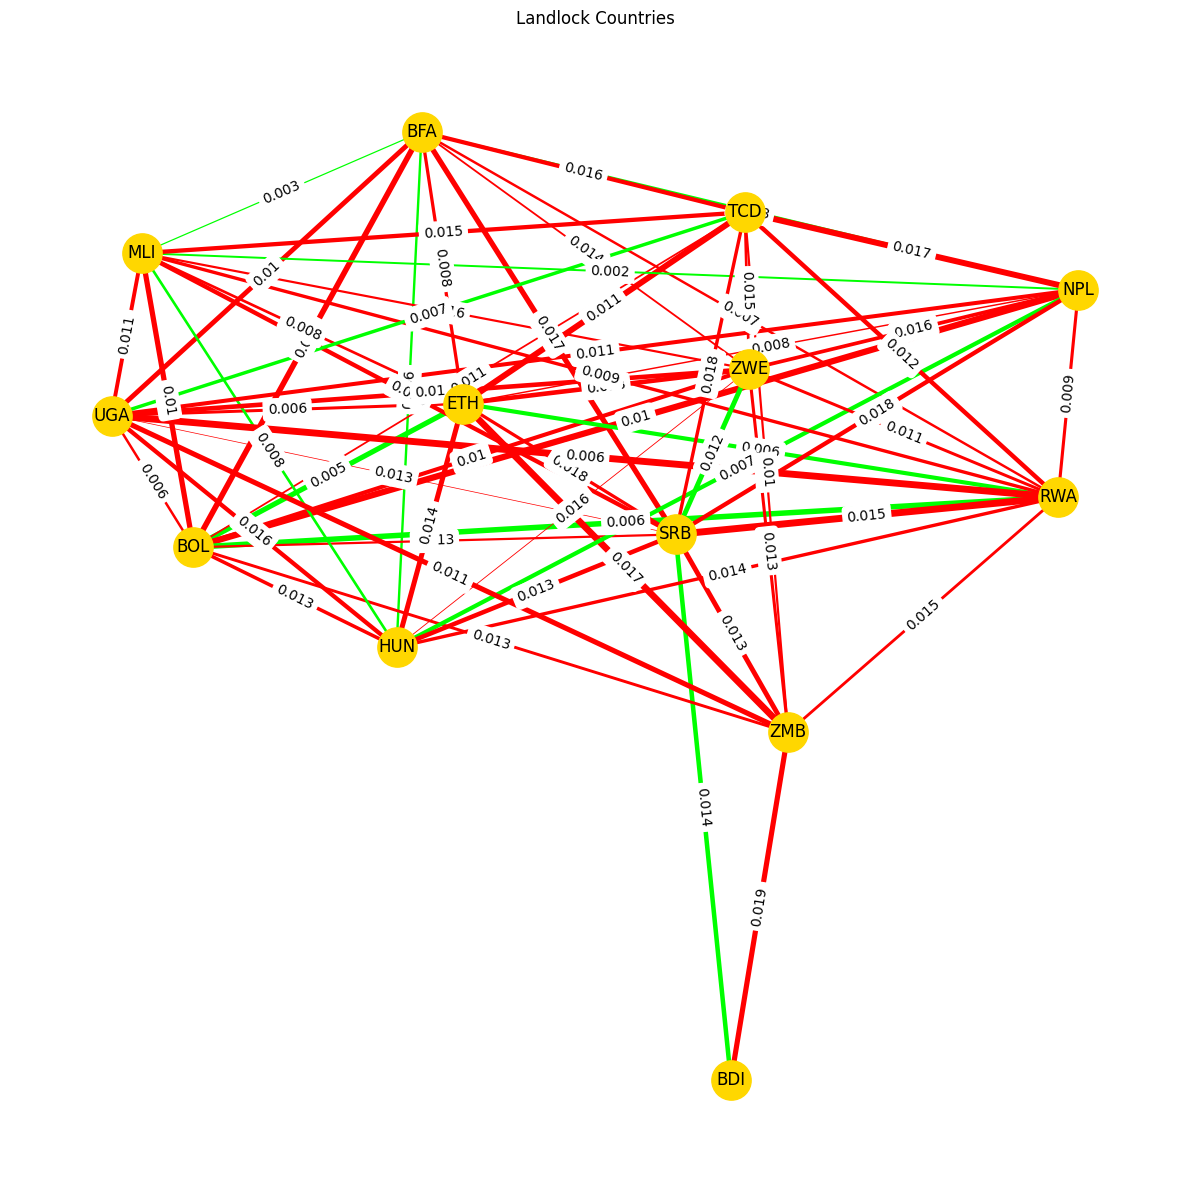

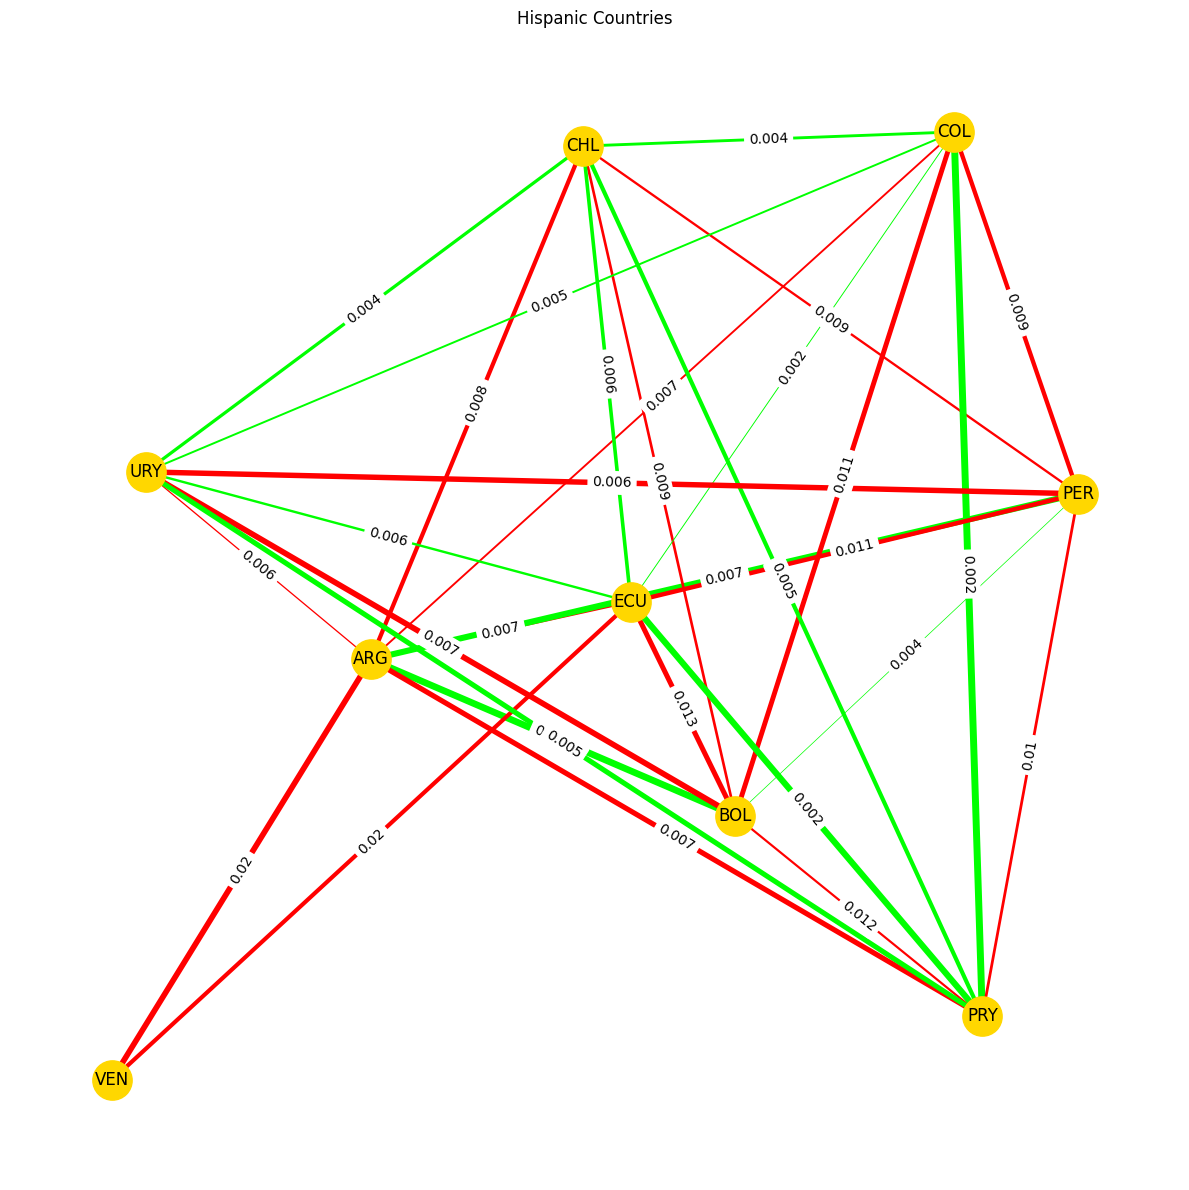

In [20]:
PostProcessing.postprocess_clustering(scaled_data_gdp, locations, names, groups, y_kkmeans)

## Conclusion
While spectral clustering on its own does not produce desirable results, it can enhance the performance of kernel $k$-means to produce the best partition of all the examined algorithms.